# Market Insights Analysis

## Libraries Importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import os
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster, cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.metrics import silhouette_score

from datetime import timedelta
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_calibration_purchases_vs_holdout_purchases

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from yellowbrick.cluster import KElbowVisualizer


import s3fs
import json
from sklearn.metrics.pairwise import cosine_similarity
import datetime as dt

from xgboost import XGBClassifier

import imblearn

import warnings
warnings.filterwarnings('ignore')


## Data Importing

In [2]:
sales = pd.read_csv('Data/sales_cleaned.csv')
sales_ori = pd.read_csv('Data/Online_Sales.csv')
products = pd.read_csv('Data/products.csv') # extract unique product ID/name/group from table 'sales'
products.set_index('Product_SKU', inplace=True)
marketing = pd.read_csv('Data/marketing_cleaned.csv')
customer = pd.read_csv('Data/CustomersData.csv')
coupon = pd.read_csv('Data/Discount_Coupon.csv')
tax = pd.read_csv('Data/Tax_amount.csv')
customer_analysis = pd.read_csv('Data/customer_analysis_encoded.csv')
product_analysis = pd.read_csv('Data/product_analysis.csv')
rfm = pd.read_csv('Data/rfm.csv')

In [3]:
customer_analysis = customer_analysis.drop(customer_analysis.columns[0], axis=1)
customer_analysis.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Monetary_Value,Predicted_Purchases,Predicted_Revenue,CLV,customer_category
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,174.981740,0.175161,1488.523498,251.968402,Segment4
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,5228.947987,1.796198,2798.601724,4856.521721,Segment2
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,844.777970,1.607770,1491.563966,2317.038963,Segment4
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,1467.435280,2.259136,1659.302471,3623.714932,Segment2
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,2007.429000,0.175161,1730.654802,292.954948,Segment4


In [4]:
rfm.head()

,Unnamed: 0,CustomerID,frequency,Days_Since_Last_Purchase,Tenure_Days,Monetary_Value,Predicted_Purchases,Predicted_Revenue,CLV,cluster,customer_category
0,0,12346,1.0,0.0,107.0,174.981740,0.175161,1488.523498,251.968402,3,Segment4
1,1,12347,3.0,223.0,282.0,5228.947987,1.796198,2798.601724,4856.521721,1,Segment2
2,2,12348,2.0,119.0,192.0,844.777970,1.607770,1491.563966,2317.038963,3,Segment4
3,3,12350,1.0,0.0,17.0,1467.435280,2.259136,1659.302471,3623.714932,1,Segment2
4,4,12356,1.0,0.0,107.0,2007.429000,0.175161,1730.654802,292.954948,3,Segment4


In [5]:
# Extract unique Product_Description for each customer
cus_prod = sales.groupby('CustomerID')['Product_Description'].unique().reset_index()
# Extract unique Product_SKU for each customer
cus_sku = sales.groupby('CustomerID')['Product_SKU'].unique().reset_index()
# Extract unique Product_Category for each customer
prod_cat = sales.groupby('CustomerID')['Product_Category'].unique().reset_index()
# Extract unique Product Group for each customer
cus_group = sales.groupby('CustomerID')['Product_Group'].unique().reset_index()

# Merge cus_prod, cus_sku, prod_cat, and cus_group together
product_analysis = pd.merge(cus_prod, cus_sku, on='CustomerID')
product_analysis = pd.merge(product_analysis, prod_cat, on='CustomerID')
product_analysis = pd.merge(product_analysis, cus_group, on='CustomerID')

# Rename columns
product_analysis.columns = ['CustomerID', 'Purchased_Products', 'Products_SKUs', 'Product_Categories', 'Product_Group']

product_analysis.head()

,CustomerID,Purchased_Products,Products_SKUs,Product_Categories,Product_Group
0,12346,[Android Men's Engineer Short Sleeve Tee Charc...,"[GGOEAAAJ080816, GGOEGOAR013099]","[Apparel, Office]","[Android, Google]"
1,12347,"[Four Color Retractable Pen, Red Spiral Google...","[GGOEGOAQ020099, GGOEGOCT019199, GGOENEBJ07949...","[Office, Nest, Bags, Drinkware, Headgear, Appa...","[No-Brand, Google, YouTube, Android]"
2,12348,"[26 oz Double Wall Insulated Bottle, Google St...","[GGOEGDHQ015399, GGOEGOAR013099, GGOEGBMJ01339...","[Drinkware, Office, Bags, Lifestyle, Apparel, ...","[No-Brand, Google, YouTube]"
3,12350,[Nest Learning Thermostat 3rd Gen-USA - Stainl...,"[GGOENEBJ079499, GGOENEBQ081599, GGOEGAEL09131...","[Nest, Apparel, Headgear]",[Google]
4,12356,"[YouTube Men's Short Sleeve Hero Tee White, R...","[GGOEYAAQ031717, GGOEGDWR015799, GGOEGADC05931...","[Apparel, Drinkware, Nest, Bags, Office, Lifes...","[YouTube, No-Brand, Google, Android]"


## Modeling

### Clustering

#### K-Means Clustering

In [6]:
# Drop these columns not to be inserted into the model
customer_analysis.drop(['customer_category', 'Monetary_Value'], axis=1, inplace=True)

In [7]:
# Instantiate StandardScaler.
ss = StandardScaler()

# Standardize customer_analysis data.
df_std = ss.fit_transform(customer_analysis)


In [8]:
# Calculate Within-Cluster-Sum-of-Squares (WCSS) for different numbers of clusters
wcss = []
for i in range(1, 20):
    # Create KMeans model with varying number of clusters (from 1 to 19)
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    
    # Fit the model to the standardized data
    kmeans.fit(df_std)
    
    # Append the WCSS (inertia) to the list
    wcss.append(kmeans.inertia_)


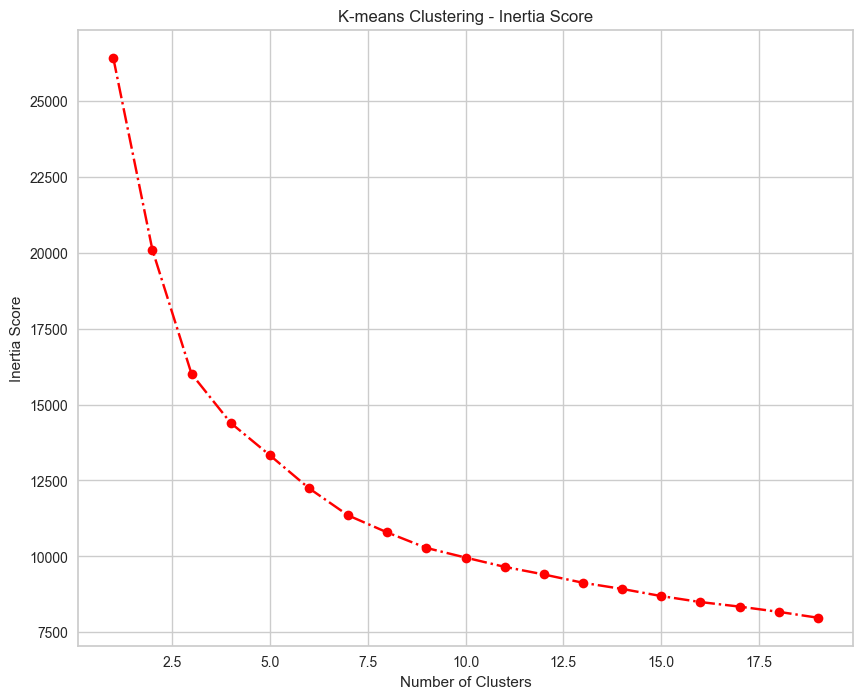

In [9]:
# Set figure size
plt.figure(figsize = (10,8))

# Line plot of WCSS score for each cluster
plt.plot(range(1, 20), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.title('K-means Clustering - Inertia Score')
plt.show()

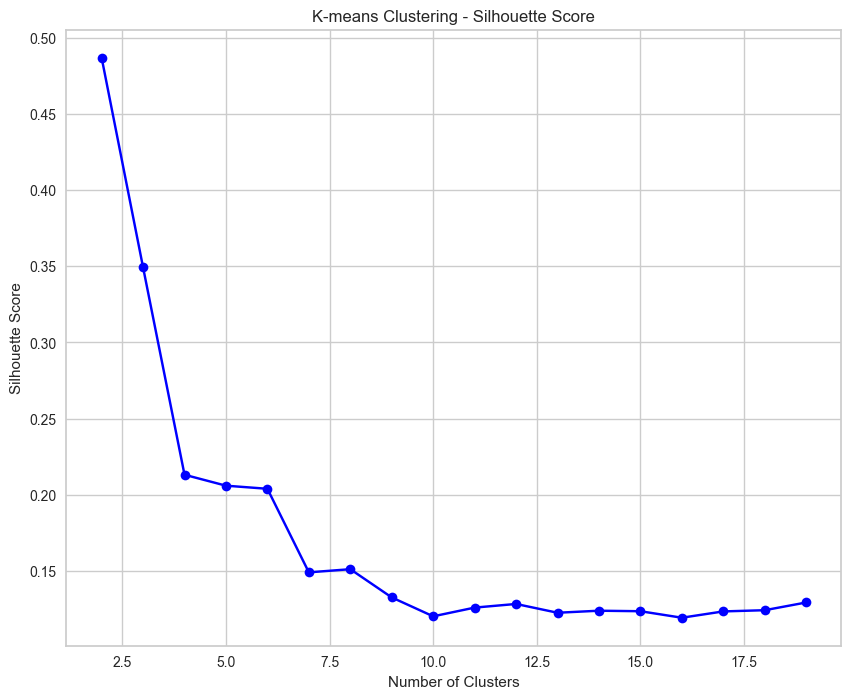

In [10]:
# Calculate Silhouette Scores for different numbers of clusters
silhouette_scores = []
for i in range(2, 20):  # Silhouette Score requires at least 2 clusters

    # Create KMeans model with varying number of clusters (from 2 to 19)
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    
    # Fit the model to the standardized data
    kmeans.fit(df_std)
    
    # Calculate the Silhouette Score and append it to the list
    silhouette = silhouette_score(df_std, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.figure(figsize=(10, 8))
plt.plot(range(2, 20), silhouette_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-means Clustering - Silhouette Score')
plt.show()

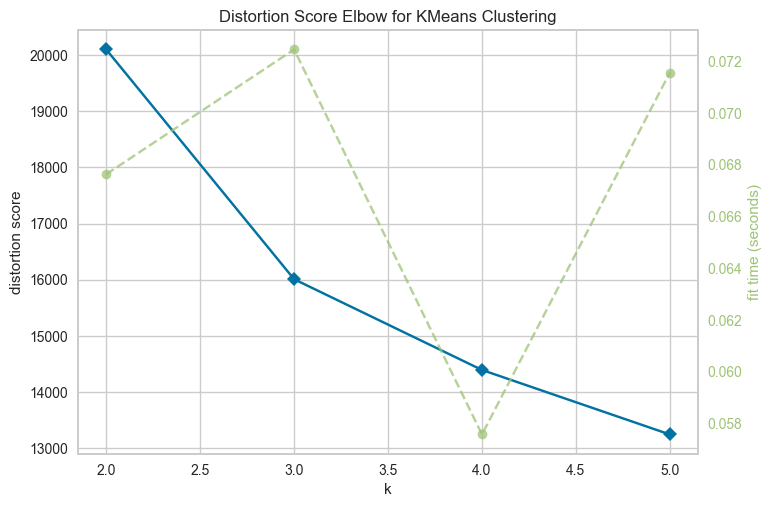

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# Instantiate the KMeans clustering model and the visualizer for elbow method to determine optimal k
km_model = KMeans()  # Initialize KMeans clustering model
visualizer = KElbowVisualizer(km_model, k=(2, 6))  # Create an elbow visualizer for k range from 2 to 10

visualizer.fit(df_std)# Fit the data to the visualizer
visualizer.show()

In [12]:
# Calculate Silhouette Scores for different numbers of clusters
silhouette_scores = []
for i in range(2, 20):  # Silhouette Score requires at least 2 clusters
    # Create KMeans model with varying number of clusters (from 2 to 19)
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    
    # Fit the model to the standardized data
    kmeans.fit(df_std)
    
    # Calculate the Silhouette Score and append it to the list
    silhouette = silhouette_score(df_std, kmeans.labels_)
    silhouette_scores.append(silhouette)

# Determine the optimal number of clusters based on the highest Silhouette Score
optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Index starts from 0, so adding 2 for the actual number of clusters

# Display the optimal number of clusters based on Silhouette Score
print(f"Optimal number of clusters based on Silhouette Score: {optimal_num_clusters}")

Optimal number of clusters based on Silhouette Score: 2


In [13]:
# Instantiate KMeans clustering with 4 clusters using k-means++ initialization and fit to standardized data
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=42)
kmeans.fit(df_std)

KMeans(random_state=42)

In [14]:
# Retrieve cluster centers (centroids) from the KMeans model
kmeans.cluster_centers_

array([[-7.20689084e-02, -3.93602255e-01, -3.06479776e-01,
        -3.61704943e-01, -2.81638512e-01,  1.66540892e-02,
         1.32252171e+00, -8.55916673e-03, -3.43015881e-01,
        -3.54851633e-01, -3.67213009e-01, -3.59883718e-01,
        -3.66721170e-01, -4.76741275e-01, -1.58892529e-01,
        -3.99269490e-01, -2.32110383e-01, -3.78923218e-01],
       [ 1.74402580e-01,  7.16711468e-01,  6.39888933e-01,
         6.65822350e-01,  6.86353049e-01,  9.75172020e-02,
        -3.13377876e-02,  3.17549717e-02,  6.24876896e-01,
         6.90055122e-01,  6.68811984e-01,  7.00958007e-01,
        -1.94803892e-01, -3.11313019e-01, -9.99011419e-02,
        -2.81038325e-01,  1.61595328e+00, -1.38390647e-01],
       [-4.10184590e-01,  1.92462019e-01, -2.14789283e-01,
        -1.47755087e-01, -2.57464442e-01,  1.40982162e-02,
         2.33636062e-02, -1.49817989e-01, -1.42821244e-01,
        -1.40021504e-01, -1.49700405e-01, -2.17646731e-02,
        -1.46854174e-01, -5.45729662e-01, -1.74360921e

In [15]:
# Predict cluster
kmeans.predict(df_std)

array([5, 1, 0, ..., 0, 5, 1], dtype=int32)

In [16]:
# Create a copy of the 'customer_analysis' DataFrame 
customer_analysis_km = customer_analysis.copy()

# Assign cluster labels as a new column 'Segment'
customer_analysis_km['Segment'] = kmeans.labels_
customer_analysis_km.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,0.175161,1488.523498,251.968402,5
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,1.796198,2798.601724,4856.521721,1
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,1.607770,1491.563966,2317.038963,0
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,2.259136,1659.302471,3623.714932,0
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,0.175161,1730.654802,292.954948,5


In [17]:
# Grouping 'customer_analysis_km' DataFrame by 'Segment' and calculating mean values for each segment
df_cluster = customer_analysis_km.groupby(['Segment']).mean()
df_cluster

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
Segment,,,,,,,,,,,,,,,,,,
0,15188.740854,818.984024,176.971768,17.652439,74.201220,2.271341,1.000000,25.792683,6.106707,2.628049,8.917683,1573.481842,1.365854,17.948171,192.024390,0.482815,1600.883827,723.058880
1,15618.440789,3821.202237,801.361382,69.921053,376.473684,2.381579,0.348684,26.355263,23.289474,11.125000,35.506579,7773.136988,1.750000,34.052632,198.197368,0.703860,2276.323582,1542.085239
2,14599.267857,2403.664821,237.466786,28.535714,81.750000,2.267857,0.375000,23.821429,9.660714,4.375000,14.500000,3549.480174,1.857143,11.232143,26.196429,6.716698,1747.064060,11035.840121
3,15182.428571,11811.677143,2736.007619,225.095238,1003.285714,2.809524,0.571429,25.761905,75.047619,34.952381,115.095238,23863.200553,7.142857,207.000000,280.095238,3.867841,2713.498956,10031.289751
4,15326.897119,1917.922798,370.530535,37.074074,132.539095,2.230453,0.374486,26.135802,12.633745,5.580247,18.860082,3475.263103,3.736626,202.979424,287.534979,2.107801,1438.794900,2785.059911
5,15336.970332,728.855428,141.466475,14.769634,62.537522,2.183246,0.000000,26.090750,4.872600,2.221640,7.675393,1382.991794,1.301920,11.849913,188.097731,0.481810,1589.972699,725.291076
6,15569.800000,5565.577111,1108.792778,108.411111,507.977778,2.211111,0.311111,24.900000,37.066667,16.377778,54.966667,11211.133195,5.055556,229.944444,293.477778,2.744123,1949.764101,4995.891233
7,15083.400000,29586.782000,7027.308000,590.400000,3413.000000,3.200000,0.200000,31.200000,209.200000,91.800000,289.400000,70779.311820,26.200000,326.200000,355.400000,9.328439,2512.341624,22665.460593


In [18]:
# Rename Segment numeric value to specific name
df_cluster.rename({0:'Segment1',
                         1:'Segment2',
                         2: 'Segment3',
                         3: 'Segment4',
                         4: 'Segment5',
                         5: 'Segment6',
                         6: 'Segment7',
                         7: 'Segment8'})

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
Segment,,,,,,,,,,,,,,,,,,
Segment1,15188.740854,818.984024,176.971768,17.652439,74.201220,2.271341,1.000000,25.792683,6.106707,2.628049,8.917683,1573.481842,1.365854,17.948171,192.024390,0.482815,1600.883827,723.058880
Segment2,15618.440789,3821.202237,801.361382,69.921053,376.473684,2.381579,0.348684,26.355263,23.289474,11.125000,35.506579,7773.136988,1.750000,34.052632,198.197368,0.703860,2276.323582,1542.085239
Segment3,14599.267857,2403.664821,237.466786,28.535714,81.750000,2.267857,0.375000,23.821429,9.660714,4.375000,14.500000,3549.480174,1.857143,11.232143,26.196429,6.716698,1747.064060,11035.840121
Segment4,15182.428571,11811.677143,2736.007619,225.095238,1003.285714,2.809524,0.571429,25.761905,75.047619,34.952381,115.095238,23863.200553,7.142857,207.000000,280.095238,3.867841,2713.498956,10031.289751
Segment5,15326.897119,1917.922798,370.530535,37.074074,132.539095,2.230453,0.374486,26.135802,12.633745,5.580247,18.860082,3475.263103,3.736626,202.979424,287.534979,2.107801,1438.794900,2785.059911
Segment6,15336.970332,728.855428,141.466475,14.769634,62.537522,2.183246,0.000000,26.090750,4.872600,2.221640,7.675393,1382.991794,1.301920,11.849913,188.097731,0.481810,1589.972699,725.291076
Segment7,15569.800000,5565.577111,1108.792778,108.411111,507.977778,2.211111,0.311111,24.900000,37.066667,16.377778,54.966667,11211.133195,5.055556,229.944444,293.477778,2.744123,1949.764101,4995.891233
Segment8,15083.400000,29586.782000,7027.308000,590.400000,3413.000000,3.200000,0.200000,31.200000,209.200000,91.800000,289.400000,70779.311820,26.200000,326.200000,355.400000,9.328439,2512.341624,22665.460593


In [19]:
df_cluster.reset_index(inplace=True)

In [20]:
segment_names = {0:'Segment1', 1:'Segment2', 2: 'Segment3', 3: 'Segment4', 4: 'Segment5', 5: 'Segment6', 6: 'Segment7', 7: 'Segment8'}

In [21]:
df_cluster['Segment'] = df_cluster['Segment'].replace(segment_names)


In [22]:
df_cluster

,Segment,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
0,Segment1,15188.740854,818.984024,176.971768,17.652439,74.201220,2.271341,1.000000,25.792683,6.106707,2.628049,8.917683,1573.481842,1.365854,17.948171,192.024390,0.482815,1600.883827,723.058880
1,Segment2,15618.440789,3821.202237,801.361382,69.921053,376.473684,2.381579,0.348684,26.355263,23.289474,11.125000,35.506579,7773.136988,1.750000,34.052632,198.197368,0.703860,2276.323582,1542.085239
2,Segment3,14599.267857,2403.664821,237.466786,28.535714,81.750000,2.267857,0.375000,23.821429,9.660714,4.375000,14.500000,3549.480174,1.857143,11.232143,26.196429,6.716698,1747.064060,11035.840121
3,Segment4,15182.428571,11811.677143,2736.007619,225.095238,1003.285714,2.809524,0.571429,25.761905,75.047619,34.952381,115.095238,23863.200553,7.142857,207.000000,280.095238,3.867841,2713.498956,10031.289751
4,Segment5,15326.897119,1917.922798,370.530535,37.074074,132.539095,2.230453,0.374486,26.135802,12.633745,5.580247,18.860082,3475.263103,3.736626,202.979424,287.534979,2.107801,1438.794900,2785.059911
5,Segment6,15336.970332,728.855428,141.466475,14.769634,62.537522,2.183246,0.000000,26.090750,4.872600,2.221640,7.675393,1382.991794,1.301920,11.849913,188.097731,0.481810,1589.972699,725.291076
6,Segment7,15569.800000,5565.577111,1108.792778,108.411111,507.977778,2.211111,0.311111,24.900000,37.066667,16.377778,54.966667,11211.133195,5.055556,229.944444,293.477778,2.744123,1949.764101,4995.891233
7,Segment8,15083.400000,29586.782000,7027.308000,590.400000,3413.000000,3.200000,0.200000,31.200000,209.200000,91.800000,289.400000,70779.311820,26.200000,326.200000,355.400000,9.328439,2512.341624,22665.460593


In [23]:
df_cluster[['Segment', 'Revenue', 'frequency', 'Days_Since_Last_Purchase', 'Tenure_Days']].sort_values(by=['Revenue', 'frequency', 'Days_Since_Last_Purchase', 'Tenure_Days'], ascending=True)


,Segment,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days
5,Segment6,1382.991794,1.301920,11.849913,188.097731
0,Segment1,1573.481842,1.365854,17.948171,192.024390
4,Segment5,3475.263103,3.736626,202.979424,287.534979
2,Segment3,3549.480174,1.857143,11.232143,26.196429
1,Segment2,7773.136988,1.750000,34.052632,198.197368
6,Segment7,11211.133195,5.055556,229.944444,293.477778
3,Segment4,23863.200553,7.142857,207.000000,280.095238
7,Segment8,70779.311820,26.200000,326.200000,355.400000


In [24]:
# Sort the DataFrame by 'Revenue' in ascending order
sorted_df = df_cluster[['Segment', 'Days_Since_Last_Purchase']].sort_values(by='Days_Since_Last_Purchase', ascending=True)

# Convert 'Revenue' column to integers (removing decimal points)
sorted_df['Days_Since_Last_Purchase'] = sorted_df['Days_Since_Last_Purchase'].astype(int)

# Display the DataFrame with 'Revenue' column without decimal points
pd.DataFrame(sorted_df)

,Segment,Days_Since_Last_Purchase
2,Segment3,11
5,Segment6,11
0,Segment1,17
1,Segment2,34
4,Segment5,202
3,Segment4,207
6,Segment7,229
7,Segment8,326


<Axes: ylabel='Frequency'>

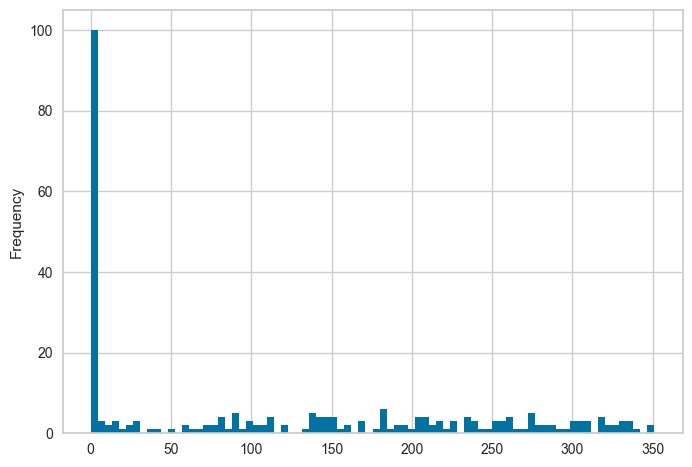

In [25]:
# Filter DataFrame for specific segments (1, 3, and 6)
segments_to_filter = [1, 3, 6]
filtered_data = customer_analysis_km[customer_analysis_km['Segment'].isin(segments_to_filter)]

# Plot a histogram for the filtered 'Days_Since_Last_Purchase' column
filtered_data[['Days_Since_Last_Purchase']].plot(kind='hist', bins=80, legend=False)

In [26]:
# Filter DataFrame for specific segments
segments_to_filter = [1, 2, 3, 4, 5, 6, 7, 8]
filtered_data = customer_analysis_km[customer_analysis_km['Segment'].isin(segments_to_filter)]

# Group by 'Segment' and count occurrences of Days_Since_Last_Purchase == 0 for each segment
zero_count_by_segment = filtered_data.groupby('Segment')['Days_Since_Last_Purchase'].apply(lambda x: (x == 0).sum()).reset_index()
zero_count_by_segment.columns = ['Segment', 'Days_Since_Last_Purchase_Count_0']

pd.DataFrame(zero_count_by_segment)

,Segment,Days_Since_Last_Purchase_Count_0
0,1,60
1,2,20
2,3,0
3,4,0
4,5,424
5,6,0
6,7,0


In [27]:
# Rename Segment numeric value to specific name
segment_name = {0:'1', 1:'2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8'}

In [28]:
df_cluster

,Segment,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
0,Segment1,15188.740854,818.984024,176.971768,17.652439,74.201220,2.271341,1.000000,25.792683,6.106707,2.628049,8.917683,1573.481842,1.365854,17.948171,192.024390,0.482815,1600.883827,723.058880
1,Segment2,15618.440789,3821.202237,801.361382,69.921053,376.473684,2.381579,0.348684,26.355263,23.289474,11.125000,35.506579,7773.136988,1.750000,34.052632,198.197368,0.703860,2276.323582,1542.085239
2,Segment3,14599.267857,2403.664821,237.466786,28.535714,81.750000,2.267857,0.375000,23.821429,9.660714,4.375000,14.500000,3549.480174,1.857143,11.232143,26.196429,6.716698,1747.064060,11035.840121
3,Segment4,15182.428571,11811.677143,2736.007619,225.095238,1003.285714,2.809524,0.571429,25.761905,75.047619,34.952381,115.095238,23863.200553,7.142857,207.000000,280.095238,3.867841,2713.498956,10031.289751
4,Segment5,15326.897119,1917.922798,370.530535,37.074074,132.539095,2.230453,0.374486,26.135802,12.633745,5.580247,18.860082,3475.263103,3.736626,202.979424,287.534979,2.107801,1438.794900,2785.059911
5,Segment6,15336.970332,728.855428,141.466475,14.769634,62.537522,2.183246,0.000000,26.090750,4.872600,2.221640,7.675393,1382.991794,1.301920,11.849913,188.097731,0.481810,1589.972699,725.291076
6,Segment7,15569.800000,5565.577111,1108.792778,108.411111,507.977778,2.211111,0.311111,24.900000,37.066667,16.377778,54.966667,11211.133195,5.055556,229.944444,293.477778,2.744123,1949.764101,4995.891233
7,Segment8,15083.400000,29586.782000,7027.308000,590.400000,3413.000000,3.200000,0.200000,31.200000,209.200000,91.800000,289.400000,70779.311820,26.200000,326.200000,355.400000,9.328439,2512.341624,22665.460593


**Segment Analysis**
- Segment 2 is a high value group of customers: Higher revenue, Higher quantity purchased, Higher transactions, Higher coupon usage, Better recency (shorter time of re-purchasing from last purchase, and Higher Frequency
- Segment 1 is a low value group of customers: Lower revenue, Lower quantity purchased, Lower transactions, Lower coupon usage, Poor recency (shorter time of re-purchasing from last purchase, and Lower Frequency
- Tenure month between Segment 1 and Segment 2 are close

In [29]:
customer_analysis.columns

Index(['CustomerID', 'Total_Spending', 'Delivery_Charges', 'Num_Transactions',
       'Total_Quantity', 'Location', 'Gender', 'Tenure_Months',
       'Used_Coupon_Count', 'Not_Use_Coupon_Count', 'Clicked_Coupon_Count',
       'Revenue', 'frequency', 'Days_Since_Last_Purchase', 'Tenure_Days',
       'Predicted_Purchases', 'Predicted_Revenue', 'CLV'],
      dtype='object')

In [30]:
# Inverse transform the standardized cluster centers to the original scale
centroids = pd.DataFrame(
    ss.inverse_transform(kmeans.cluster_centers_),  # Apply inverse transformation to standardized cluster centers
    columns=[  # Assigning meaningful column names to the centroids based on the original features
        'CustomerID', 'Total_Spending', 'Delivery_Charges', 'Num_Transactions',
        'Total_Quantity', 'Location', 'Gender', 'Tenure_Months',
        'Used_Coupon_Count', 'Not_Use_Coupon_Count', 'Clicked_Coupon_Count',
        'Revenue', 'frequency', 'Days_Since_Last_Purchase', 'T', 'predicted_purchases',
        'pred_monetary', 'CLV'
    ]
)


In [31]:
customer_analysis_km.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,0.175161,1488.523498,251.968402,5
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,1.796198,2798.601724,4856.521721,1
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,1.607770,1491.563966,2317.038963,0
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,2.259136,1659.302471,3623.714932,0
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,0.175161,1730.654802,292.954948,5


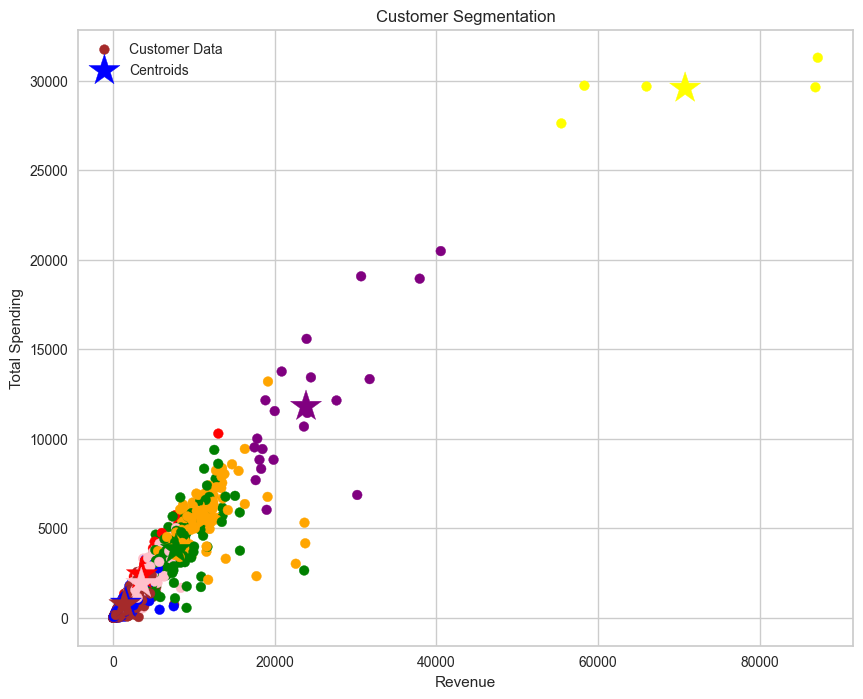

In [32]:
plt.figure(figsize=(10,8))  # Create a new figure

# Plotting customer data points
colors = ["blue", "green", "red", "purple", "pink", "brown", "orange", "yellow"]  # Define colors for each cluster
customer_analysis_km['color'] = customer_analysis_km['Segment'].map(lambda p: colors[p])  # Assign colors to segments

plt.scatter(
    x=customer_analysis_km['Revenue'], y=customer_analysis_km['Total_Spending'],
    c=customer_analysis_km['color'], label='Customer Data'  # Color points based on 'Segment'
)

# Plotting centroids
centroids = centroids[['Revenue', 'Total_Spending']]  # Assuming 'centroids' has these columns
plt.scatter(
    x=centroids['Revenue'], y=centroids['Total_Spending'], 
    marker="*", c=["blue", "green", "red", "purple", "pink", "brown", "orange", "yellow"], s=550, label='Centroids'  # Markers and colors for centroids
)

plt.xlabel('Revenue')
plt.ylabel('Total Spending')
plt.title('Customer Segmentation')
plt.legend()
plt.show()


In [33]:
# Create a mapping dictionary
mapping = {0: 'Segment1', 1: 'Segment2', 2: 'Segment3', 3: 'Segment4', 4: 'Segment5', 5: 'Segment6',
           6: 'Segment7', 7: 'Segment8'}

# Map values in the 'Segment' column using the mapping dictionary
customer_analysis_km['Segment'] = customer_analysis_km['Segment'].map(mapping)

In [34]:
# Filter the DataFrame based on 'Segment' column equal to 'Segment1' or 'Segment6'
segment2_data = customer_analysis_km[customer_analysis_km['Segment'].isin(['Segment1', 'Segment6'])]

# Group the filtered data by 'Location' and calculate the count of customers for each location
customer_count_by_location = segment2_data.groupby('Location')['CustomerID'].size()

print(customer_count_by_location)

Location
0     96
1    196
2    298
3     40
4    271
Name: CustomerID, dtype: int64


In [35]:
# Filter the DataFrame based on 'Segment' column equal to 'Segment1' or 'Segment6'
segment2_data = customer_analysis_km[customer_analysis_km['Segment'].isin(['Segment1', 'Segment6'])]

# Group the filtered data by 'Location' and calculate the count of customers for each location
customer_count_by_gender = segment2_data.groupby('Gender')['CustomerID'].size()

print(customer_count_by_gender)

Gender
0    573
1    328
Name: CustomerID, dtype: int64


In [36]:
# Filter the DataFrame based on 'Segment' column equal to 'Segment2'
segment2_data = customer_analysis_km[customer_analysis_km['Segment'] == 'Segment2']

# Group the filtered data by 'Location' and calculate the count of customers for each location
customer_count_by_gender = segment2_data.groupby('Gender')['CustomerID'].size()

# Display the count of customers for each location in Segment2
print(customer_count_by_gender)

Gender
0    99
1    53
Name: CustomerID, dtype: int64


In [37]:
{'New Jersey': 0,
 'New York': 1,
 'California': 2,
 'Washington DC': 3,
 'Chicago': 4}

{'New Jersey': 0,
 'New York': 1,
 'California': 2,
 'Washington DC': 3,
 'Chicago': 4}

In [38]:
{'F': 0, 'M': 1}

{'F': 0, 'M': 1}

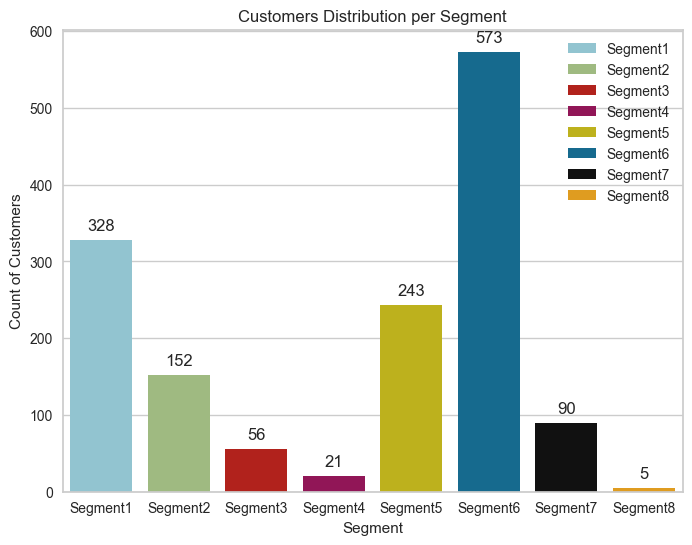

In [39]:
xticks=['Segment1','Segment2','Segment3','Segment4', 'Segment5', 'Segment6', 'Segment7', 'Segment8']

plt.figure(figsize=(8, 6))

# Create a countplot comparing 'Revenue' across different segments
s = sns.countplot(x=customer_analysis_km['Segment'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])


# Set labels and title
plt.ylabel('Count of Customers')
plt.title('Customers Distribution per Segment')
plt.legend(['Segment1', 'Segment2', 'Segment3', 'Segment4', 'Segment5', 'Segment6', 'Segment7', 'Segment8'], loc='upper right')

# Annotate each bar with its count value
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha='center', va='center', 
               xytext=(0, 10), 
               textcoords='offset points')

plt.show()


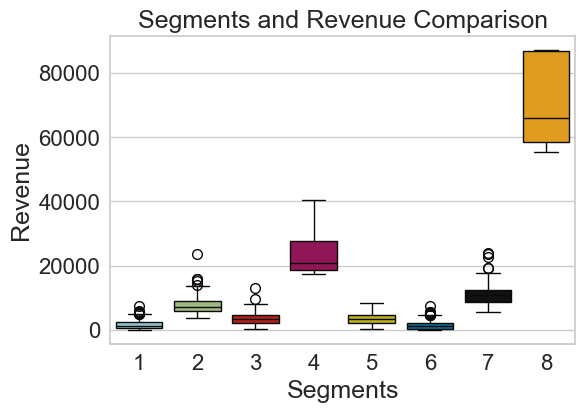

In [40]:
plt.figure(figsize=(6, 4))

# Create a boxplot comparing 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Revenue'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title with increased font sizes
plt.ylabel('Revenue', fontsize=18)  # Adjust fontsize as needed
plt.xlabel('Segments', fontsize=18)  # Adjust fontsize as needed
plt.title('Segments and Revenue Comparison', fontsize=18)  # Adjust fontsize as needed

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  # Adjust fontsize as needed for x ticks
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  # Adjust fontsize as needed for y ticks

plt.show()

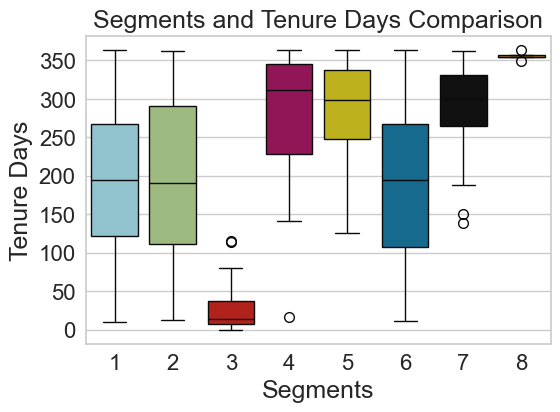

In [41]:
plt.figure(figsize=(6, 4))

# Create a boxplot comparing 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Tenure_Days'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title with increased font sizes
plt.ylabel('Tenure Days', fontsize=18)  # Adjust fontsize as needed
plt.xlabel('Segments', fontsize=18)  # Adjust fontsize as needed
plt.title('Segments and Tenure Days Comparison', fontsize=18)  # Adjust fontsize as needed

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  # Adjust fontsize as needed for x ticks
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  # Adjust fontsize as needed for y ticks

plt.show()

# people who have not come back, send email to make then come back
# 1, 6: been customers for atleast half a year

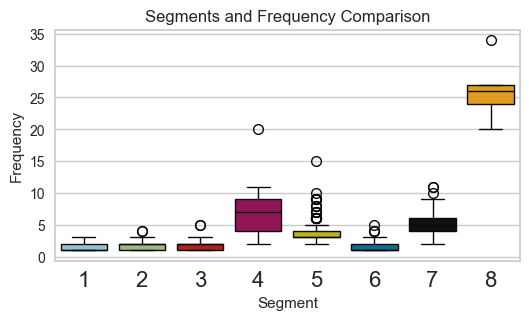

In [42]:
plt.figure(figsize=(6, 3))

# Create a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['frequency'], order=xticks,  palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Frequency')
plt.title('Segments and Frequency Comparison')

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  # Adjust fontsize as needed for x ticks
s.set_xticklabels(range(1,9))

plt.show()


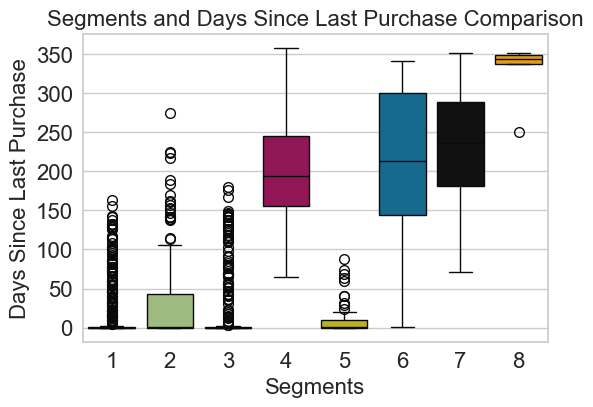

In [43]:
plt.figure(figsize=(6, 4))

# Create a boxplot to compare 'recency' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Days_Since_Last_Purchase'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Days Since Last Purchase', fontsize=16)
plt.xlabel('Segments', fontsize=16) 
plt.title('Segments and Days Since Last Purchase Comparison', fontsize=16)

# Increase x-axis tick label font size
plt.xticks(fontsize=16)
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  

plt.show()

segment 4 only purchase less frequently

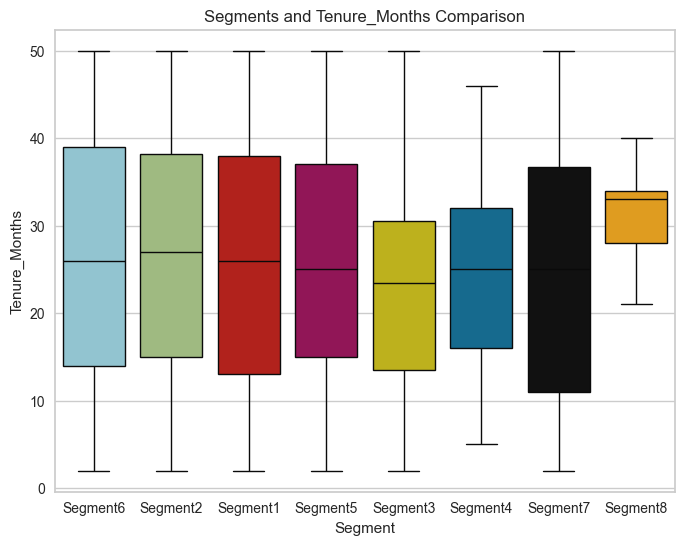

In [44]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'Tenure_Months' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Tenure_Months'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Tenure_Months')
plt.title('Segments and Tenure_Months Comparison')

plt.show()

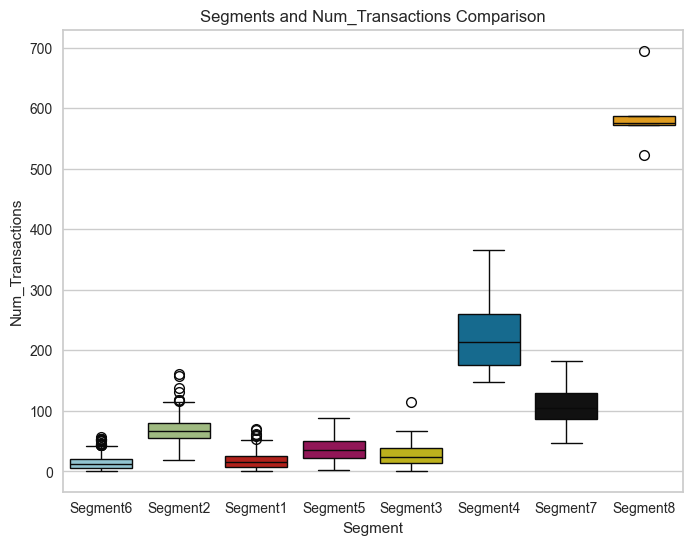

In [45]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'Num_Transactions' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Num_Transactions'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Num_Transactions')
plt.title('Segments and Num_Transactions Comparison')

plt.show()

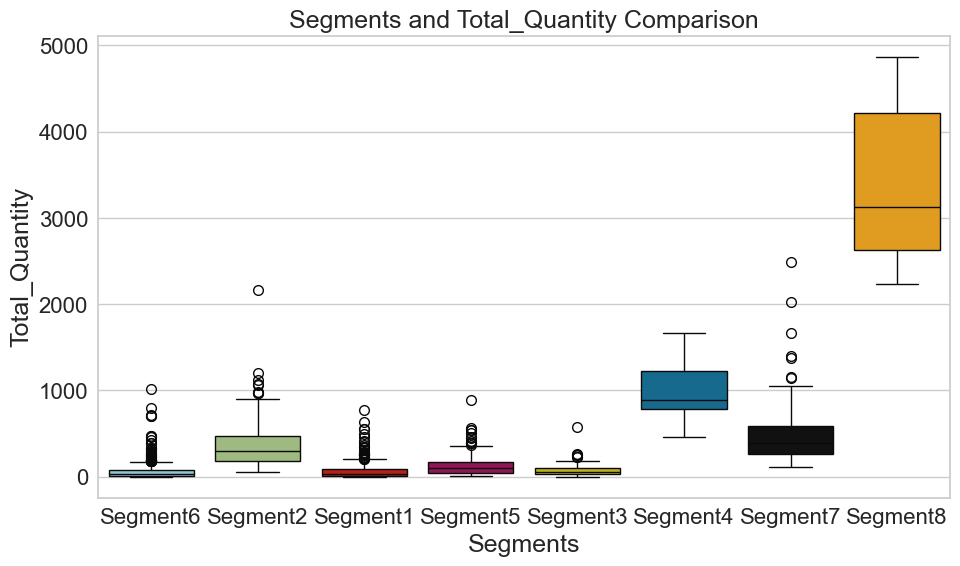

In [46]:
plt.figure(figsize=(11, 6))

# Create a boxplot to compare 'Total_Quantity' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Total_Quantity'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Total_Quantity', fontsize=18)
plt.xlabel('Segments', fontsize=18) 
plt.title('Segments and Total_Quantity Comparison', fontsize=18)

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  

plt.show()

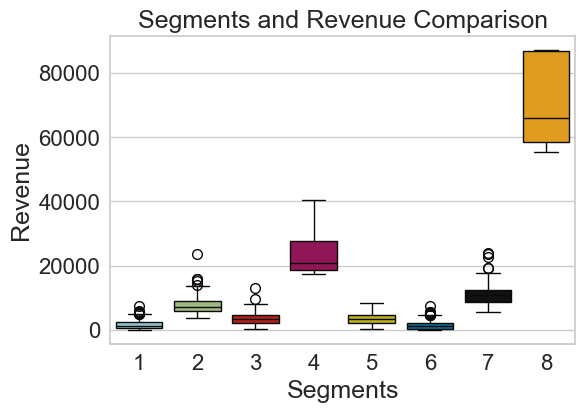

In [47]:
plt.figure(figsize=(6, 4))

# Create a boxplot comparing 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Revenue'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title with increased font sizes
plt.ylabel('Revenue', fontsize=18)  # Adjust fontsize as needed
plt.xlabel('Segments', fontsize=18)  # Adjust fontsize as needed
plt.title('Segments and Revenue Comparison', fontsize=18)  # Adjust fontsize as needed

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  # Adjust fontsize as needed for x ticks
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  # Adjust fontsize as needed for y ticks

plt.show()

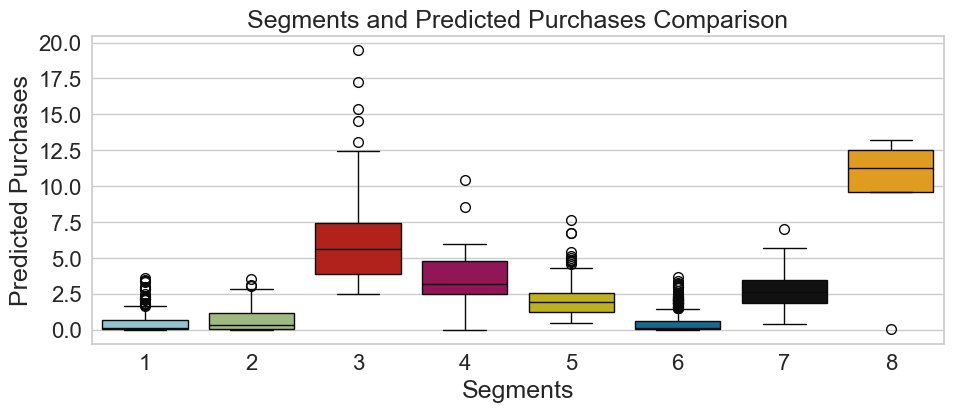

In [48]:
plt.figure(figsize=(11, 4))

# Create a boxplot to compare 'predicted_purchases' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Predicted_Purchases'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Predicted Purchases', fontsize=18)
plt.xlabel('Segments', fontsize=18) 
plt.title('Segments and Predicted Purchases Comparison', fontsize=18)

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  

plt.show()


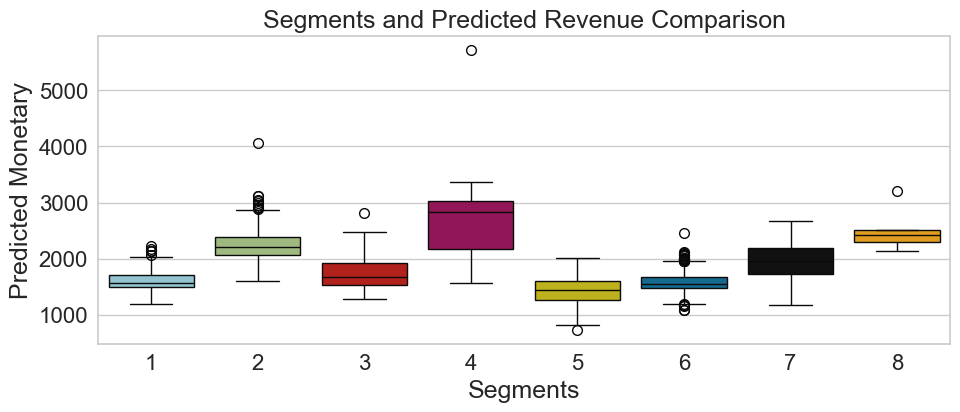

In [49]:
plt.figure(figsize=(11, 4))

# Create a boxplot to compare 'pred_monetary' across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Predicted_Revenue'], order=xticks, palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Predicted Monetary', fontsize=18)
plt.xlabel('Segments', fontsize=18) 
plt.title('Segments and Predicted Revenue Comparison', fontsize=18)

# Increase x-axis tick label font size
plt.xticks(fontsize=16)  
s.set_xticklabels(range(1,9))

# Increase y-axis tick label font size
plt.yticks(fontsize=16)  

plt.show()


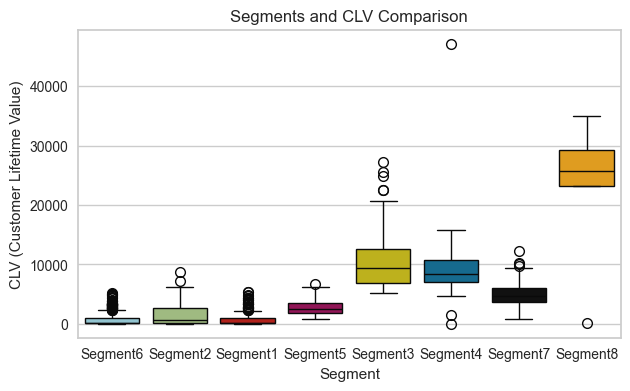

In [50]:
plt.figure(figsize=(7, 4))

# Create a boxplot to compare 'CLV' (Customer Lifetime Value) across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['CLV'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('CLV (Customer Lifetime Value)')
plt.title('Segments and CLV Comparison')

plt.show()


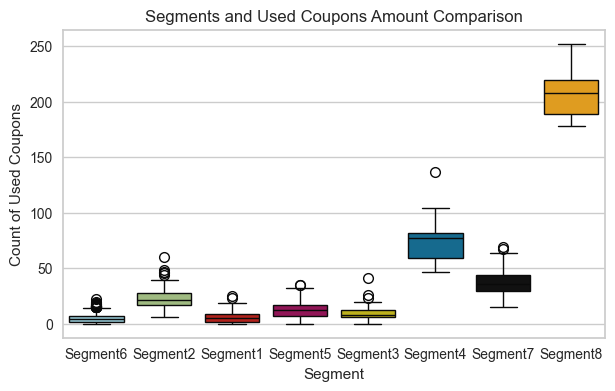

In [51]:
plt.figure(figsize=(7, 4))

# Create a boxplot to compare 'CLV' (Customer Lifetime Value) across different segments
s = sns.boxplot(x=customer_analysis_km['Segment'], y=customer_analysis_km['Used_Coupon_Count'], palette=['c', 'g', 'r', 'm', 'y', 'b', 'k', 'orange'])

# Set labels and title
plt.ylabel('Count of Used Coupons')
plt.title('Segments and Used Coupons Amount Comparison')

plt.show()


**K-Means Clustering Analysis**
- Valuable group: Segment4>Segment2>Segment3>Segment1


#### DBSCAN

In [52]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
df_std = ss.fit_transform(customer_analysis)


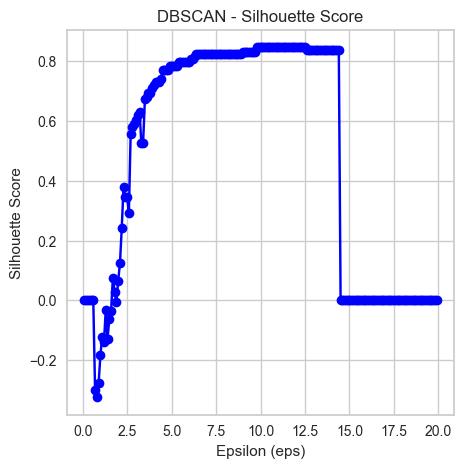

In [53]:
silhouette_scores = []
eps_values = np.arange(0.1, 20.0, 0.1)  # Range of epsilon values to try

for eps in eps_values:
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(df_std)
    
    # If all labels are -1 (noise) in DBSCAN, silhouette score cannot be calculated
    if len(np.unique(dbscan.labels_)) > 1:
        silhouette = silhouette_score(df_std, dbscan.labels_)
        silhouette_scores.append(silhouette)
    else:
        silhouette_scores.append(0)  # Assign 0 for silhouette score if all noise points
    
plt.figure(figsize=(5, 5))
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN - Silhouette Score')
plt.show()

In [54]:
# Initializing DBSCAN model with a specific epsilon value (eps=11)
dbscan = DBSCAN(eps=11)

# Fitting DBSCAN model on the standardized data
dbscan.fit(df_std)

# Retrieving the labels assigned by DBSCAN to each data point
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
# Retrieve unique labels of dbscan
np.unique(dbscan.labels_)

array([-1,  0])

In [56]:
# Create copy of customer_analysis dataframe
customer_analysis_db = customer_analysis.copy()
# Create new column segment that adds labels of dbscan
customer_analysis_db['Segment'] = dbscan.labels_
customer_analysis_db.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,0.175161,1488.523498,251.968402,0
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,1.796198,2798.601724,4856.521721,0
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,1.607770,1491.563966,2317.038963,0
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,2.259136,1659.302471,3623.714932,0
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,0.175161,1730.654802,292.954948,0


In [57]:
# Create a mapping dictionary
mapping = {0: 'Segment1', -1: 'Segment2'}

# Map values in the 'Segment' column using the mapping dictionary
customer_analysis_db['Segment'] = customer_analysis_db['Segment'].map(mapping)

In [58]:
# Group segments and calculate mean of each category
df_dbscan = customer_analysis_db.groupby(['Segment']).mean()
df_dbscan

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
Segment,,,,,,,,,,,,,,,,,,
Segment1,15313.79275,1776.846505,354.931943,34.002736,150.150479,2.245554,0.364569,25.881669,11.475376,5.188782,17.338577,3423.753029,2.103283,63.50684,208.280438,1.196601,1680.128937,1911.819486
Segment2,15459.00000,27812.601667,6287.428333,535.333333,3085.500000,3.000000,0.166667,33.333333,187.833333,84.666667,262.833333,65305.302902,22.166667,272.00000,299.000000,9.194105,3047.272416,26743.861722


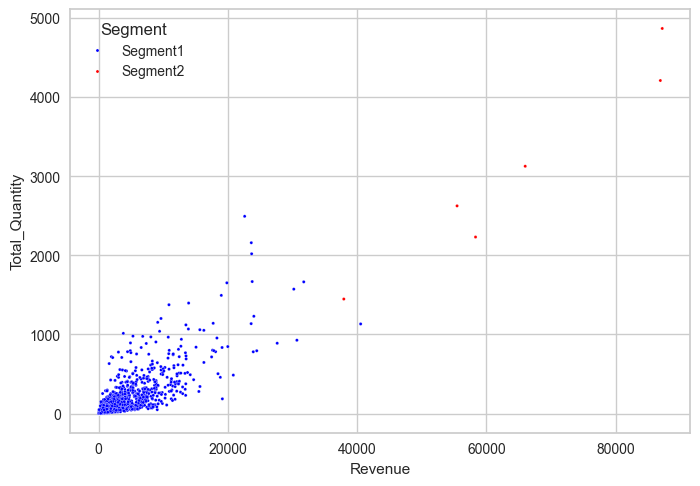

In [59]:
custom_palette = {
    'Segment1': 'blue',  # Assigning 'red' to the segment with value 0
    'Segment2': 'red'  # Assigning 'yellow' to the segment with value -1
    # Add more colors as needed for other unique segment values
}

# Create the scatterplot using the defined palette and 'Segment' as hue
sns.scatterplot(
    x="Revenue",
    y="Total_Quantity",
    hue="Segment",
    s=5,
    data=customer_analysis_db,
    palette=custom_palette
);

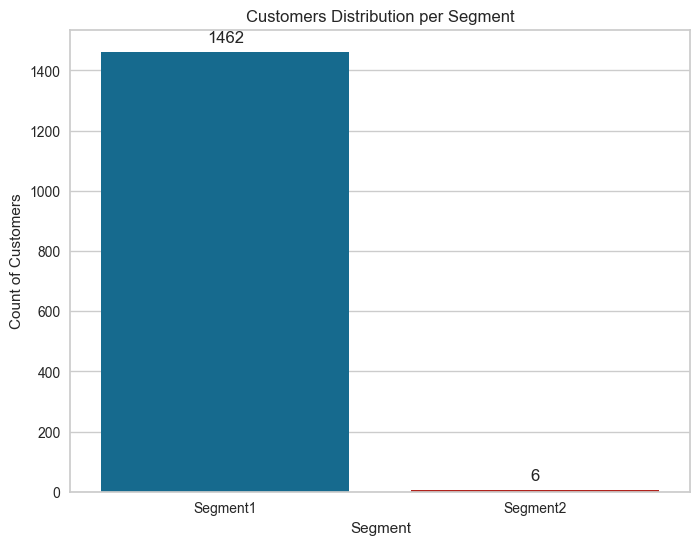

In [60]:
plt.figure(figsize=(8, 6))

# Create a countplot comparing 'Revenue' across different segments
s = sns.countplot(x=customer_analysis_db['Segment'], palette=['b', 'r'])

# Set labels and title
plt.ylabel('Count of Customers')
plt.title('Customers Distribution per Segment')

# Annotate each bar with its count value
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha='center', va='center', 
               xytext=(0, 10), 
               textcoords='offset points')

plt.show()


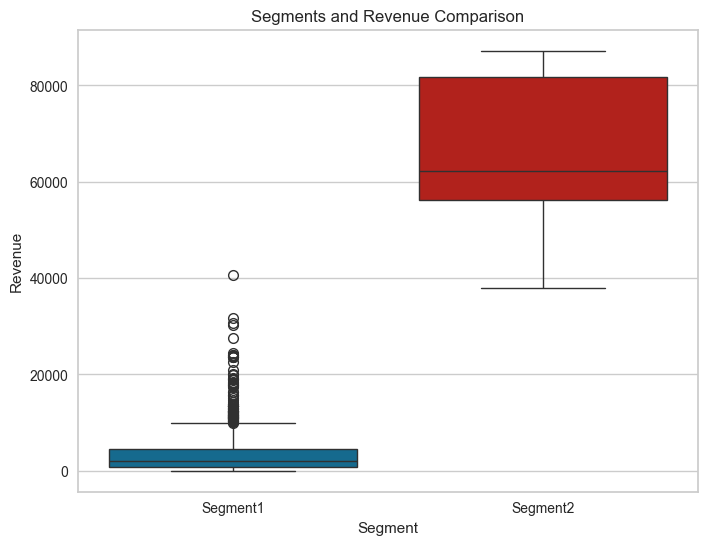

In [61]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Revenue'], palette=['b','r'])

# Setting labels and title
plt.ylabel('Revenue')
plt.title('Segments and Revenue Comparison')

plt.show()


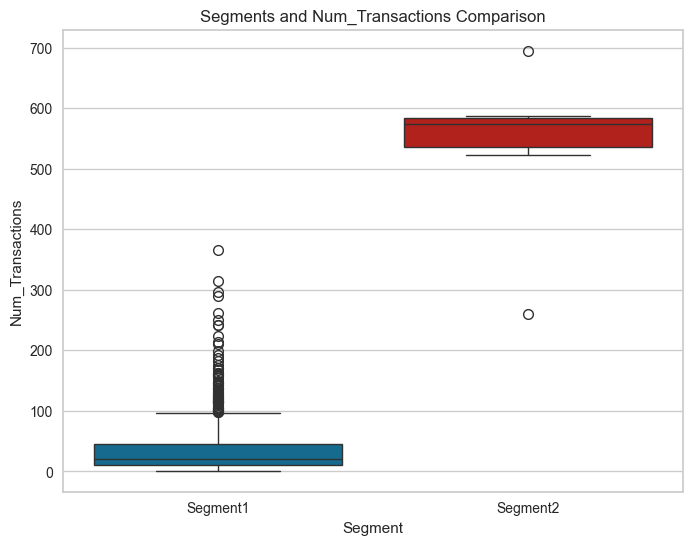

In [62]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Num_Transactions' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Num_Transactions'], palette=['b','r'])

# Setting labels and title
plt.ylabel('Num_Transactions')
plt.title('Segments and Num_Transactions Comparison')

plt.show()

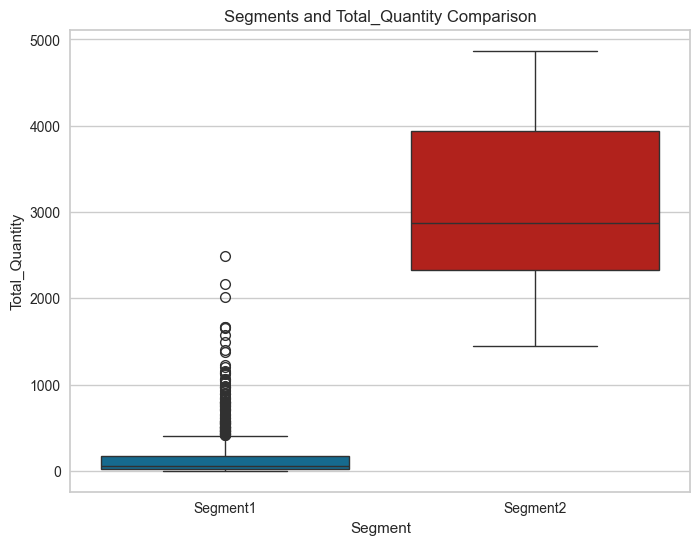

In [63]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'Total_Quantity' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Total_Quantity'], palette=['b','r'])

# Set labels and title
plt.ylabel('Total_Quantity')
plt.title('Segments and Total_Quantity Comparison')

plt.show()

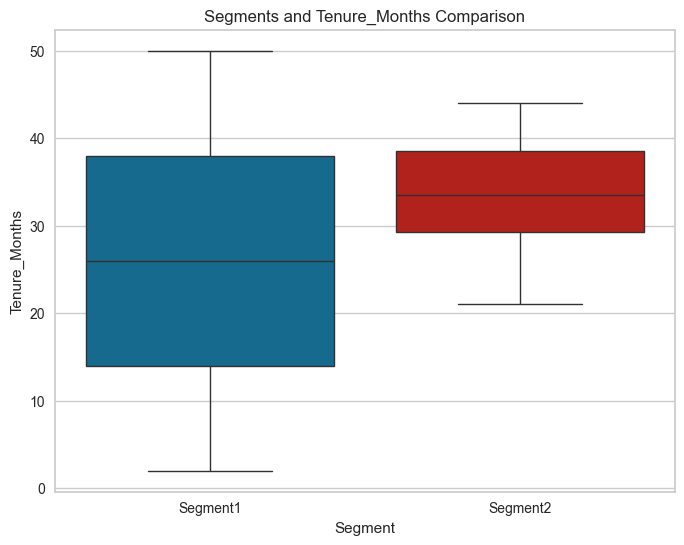

In [64]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'Tenure_Months' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Tenure_Months'], palette=['b','r'])

# Set labels and title
plt.ylabel('Tenure_Months')
plt.title('Segments and Tenure_Months Comparison')

plt.show()


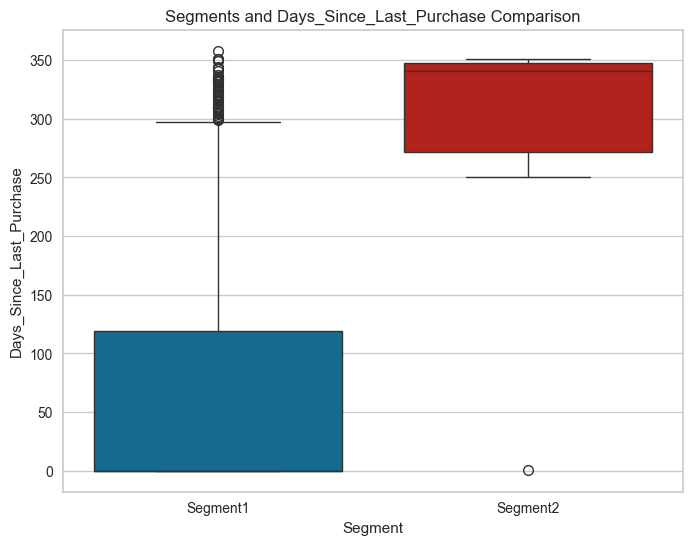

In [65]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'recency' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Days_Since_Last_Purchase'], palette=['b','r'])

# Setting labels and title
plt.ylabel('Days_Since_Last_Purchase')
plt.title('Segments and Days_Since_Last_Purchase Comparison')

plt.show()

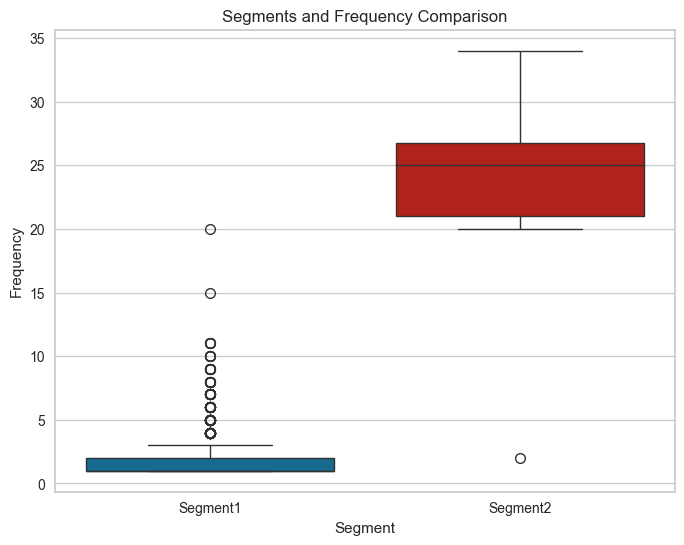

In [66]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['frequency'], palette=['b','r'])

# Set labels and title
plt.ylabel('Frequency')
plt.title('Segments and Frequency Comparison')

plt.show()


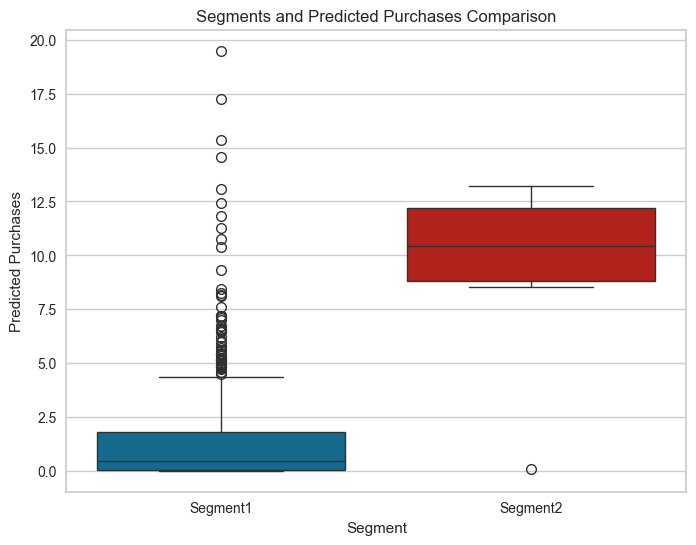

In [67]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Predicted_Purchases'], palette=['b','r'])

# Set labels and title
plt.ylabel('Predicted Purchases')
plt.title('Segments and Predicted Purchases Comparison')

plt.show()


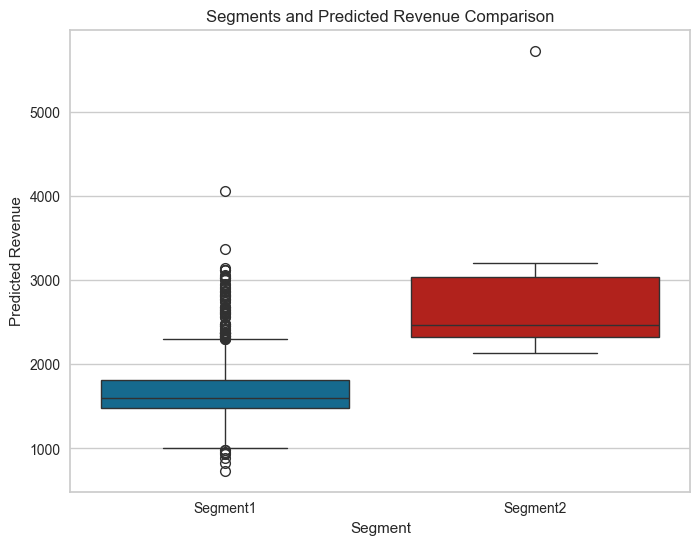

In [68]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['Predicted_Revenue'], palette=['b','r'])

# Set labels and title
plt.ylabel('Predicted Revenue')
plt.title('Segments and Predicted Revenue Comparison')

plt.show()


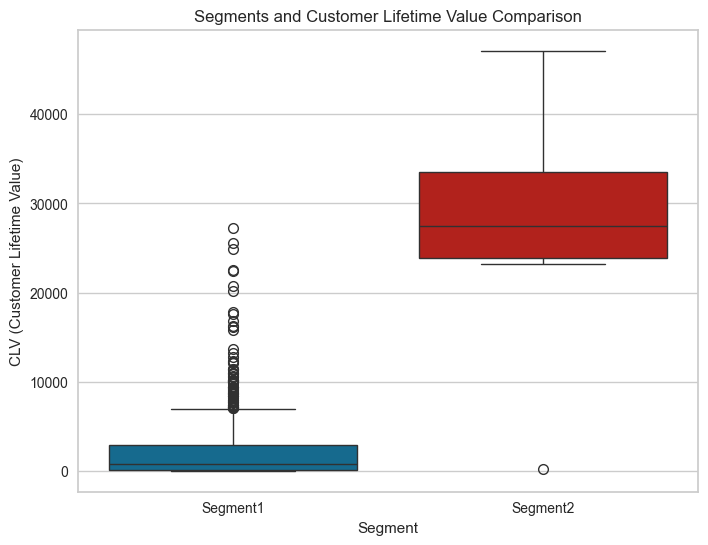

In [69]:
plt.figure(figsize=(8, 6))

# Create a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_db['Segment'], y=customer_analysis_db['CLV'], palette=['b','r'])

# Set labels and title
plt.ylabel('CLV (Customer Lifetime Value)')
plt.title('Segments and Customer Lifetime Value Comparison')

plt.show()


#### Hierarchical Clustering

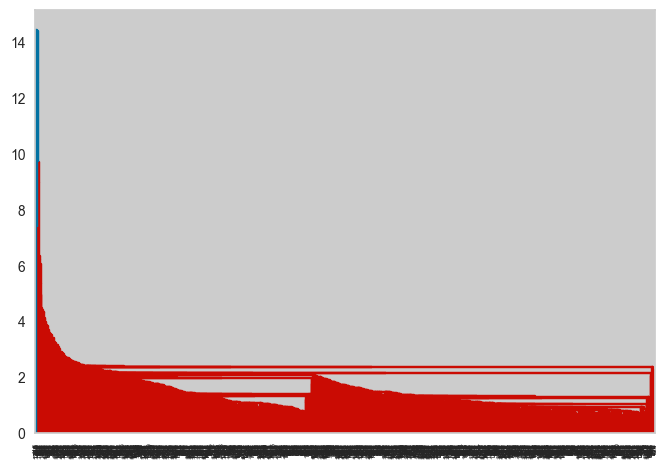

In [70]:
# Hierarchical clustering using the single linkage method ('method="single"') and Euclidean distance ('metric='euclidean'').
mergings = linkage(df_std, method="single", metric='euclidean')
# Creates a dendrogram to display the hierarchical relationships between data points.
dendrogram(mergings)
plt.show()


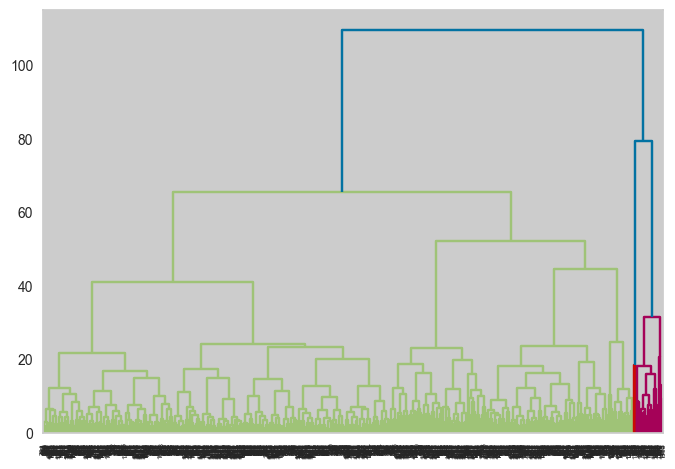

In [71]:
# Hierarchical clustering using the complete linkage method ('method="complete"') and Euclidean distance ('metric='euclidean'').
mergings = linkage(df_std, method="ward", metric='euclidean')
# Creates a dendrogram to illustrate the hierarchical relationships between data points.
dendrogram(mergings)
plt.show()

In [72]:
# Cut_tree function to assign cluster labels to each data point based on the hierarchical clustering created earlier.
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
# Show unique cluster labels
unique_cluster_labels = np.unique(cluster_labels)
print(unique_cluster_labels)


[0 1 2]


In [74]:
# Create copy of cluster_analysis
customer_analysis_hk = customer_analysis.copy()
# Create Segment column assigned with labels
customer_analysis_hk['Segment'] = cluster_labels
customer_analysis_hk.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,0.175161,1488.523498,251.968402,0
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,1.796198,2798.601724,4856.521721,0
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,1.607770,1491.563966,2317.038963,0
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,2.259136,1659.302471,3623.714932,0
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,0.175161,1730.654802,292.954948,0


In [75]:
# Create a mapping dictionary
mapping = {0: 'Segment1', 1: 'Segment2', 2: 'Segment3'}

# Map values in the 'Segment' column using the mapping dictionary
customer_analysis_hk['Segment'] = customer_analysis_hk['Segment'].replace(mapping)


In [76]:
# Preview the data
customer_analysis_hk.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,0.0,174.98174,1.0,0.0,107.0,0.175161,1488.523498,251.968402,Segment1
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,26.0,15686.84396,3.0,223.0,282.0,1.796198,2798.601724,4856.521721,Segment1
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,11.0,1689.55594,2.0,119.0,192.0,1.607770,1491.563966,2317.038963,Segment1
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,8.0,1467.43528,1.0,0.0,17.0,2.259136,1659.302471,3623.714932,Segment1
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,17.0,2007.42900,1.0,0.0,107.0,0.175161,1730.654802,292.954948,Segment1


In [77]:
# Group the data by segment and calculate mean of each category
df_hcluster = customer_analysis_hk.groupby(['Segment']).mean()
df_hcluster

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue,frequency,Days_Since_Last_Purchase,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV
Segment,,,,,,,,,,,,,,,,,,
Segment1,15328.279286,1500.48590,294.953786,28.624286,121.772143,2.252143,0.362143,25.913571,9.664286,4.365000,14.595000,2841.517508,1.924286,56.260000,204.602857,1.102127,1655.701514,1694.785485
Segment2,15023.984127,8190.65127,1723.225873,157.111111,801.380952,2.095238,0.412698,25.460317,52.825397,24.190476,80.095238,16910.121838,6.079365,223.555556,286.968254,3.412307,2287.116070,7452.639323
Segment3,15083.400000,29586.78200,7027.308000,590.400000,3413.000000,3.200000,0.200000,31.200000,209.200000,91.800000,289.400000,70779.311820,26.200000,326.200000,355.400000,9.328439,2512.341624,22665.460593


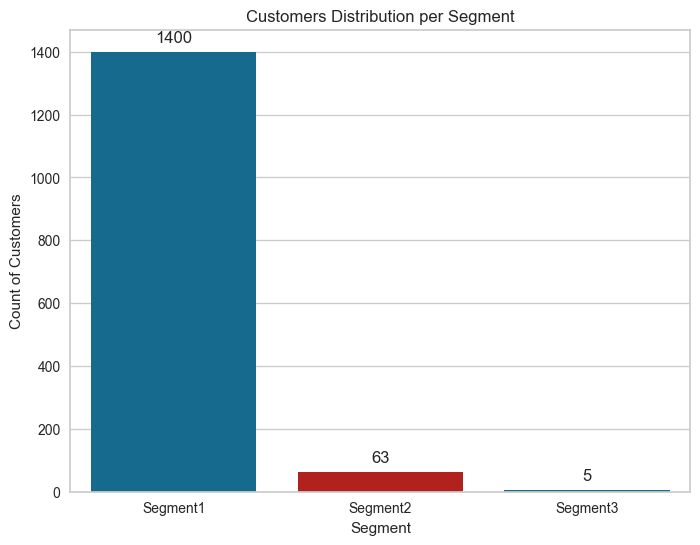

In [78]:
plt.figure(figsize=(8, 6))

# Create a countplot comparing 'Revenue' across different segments
s = sns.countplot(x=customer_analysis_hk['Segment'], palette=['b', 'r'])

# Set labels and title
plt.ylabel('Count of Customers')
plt.title('Customers Distribution per Segment')

# Annotate each bar with its count value
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha='center', va='center', 
               xytext=(0, 10), 
               textcoords='offset points')

plt.show()


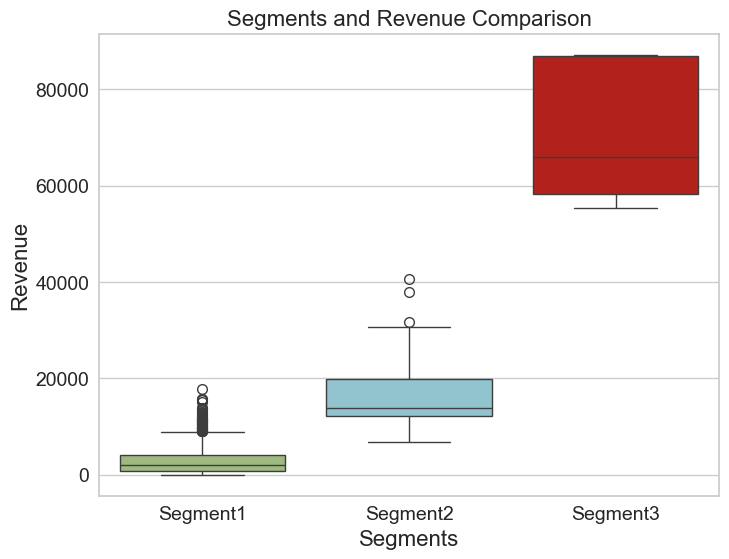

In [79]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Revenue'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Revenue', fontsize=16)
plt.xlabel('Segments', fontsize=16)
plt.title('Segments and Revenue Comparison', fontsize=16)

# Increase x-axis tick label font size
plt.xticks(fontsize=14)
# Increase y-axis tick label font size
plt.yticks(fontsize=14) 

plt.show()

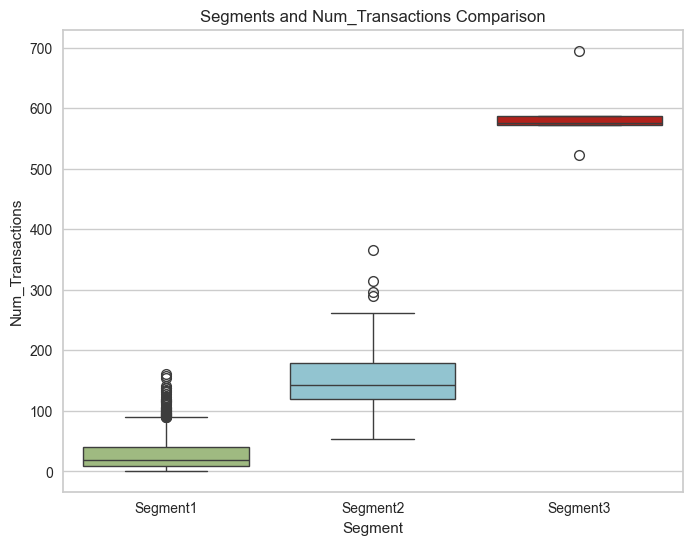

In [80]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Num_Transactions' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Num_Transactions'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Num_Transactions')
plt.title('Segments and Num_Transactions Comparison')

plt.show()

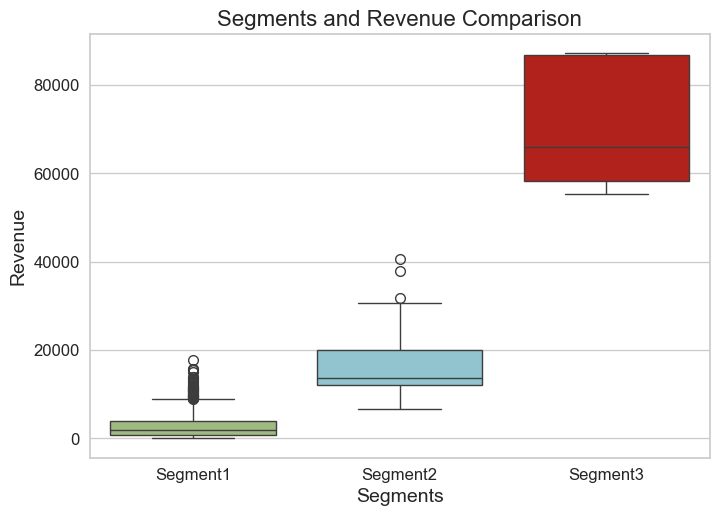

In [81]:

# Create a boxplot comparing 'Revenue' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Revenue'], palette=['g', 'c', 'r'])

# Set labels and title with increased font sizes
plt.ylabel('Revenue', fontsize=14)  # Adjust fontsize as needed
plt.xlabel('Segments', fontsize=14)  # Adjust fontsize as needed
plt.title('Segments and Revenue Comparison', fontsize=16)  # Adjust fontsize as needed

# Increase x-axis tick label font size
plt.xticks(fontsize=12)  # Adjust fontsize as needed for x ticks

# Increase y-axis tick label font size
plt.yticks(fontsize=12)  # Adjust fontsize as needed for y ticks

plt.show()

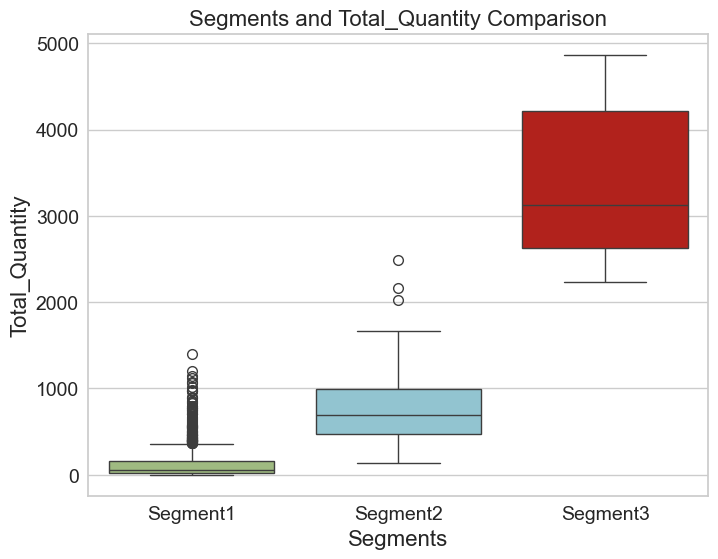

In [82]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Total_Quantity' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Total_Quantity'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Total_Quantity', fontsize=16)
plt.xlabel('Segments', fontsize=16)
plt.title('Segments and Total_Quantity Comparison', fontsize=16)

# Increase x-axis tick label font size
plt.xticks(fontsize=14)

# Increase y-axis tick label font size
plt.yticks(fontsize=14)

plt.show()

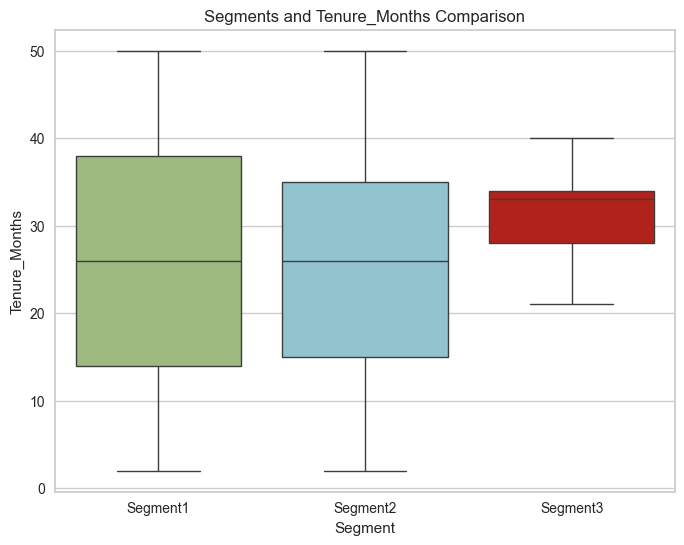

In [83]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'Tenure_Months' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Tenure_Months'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Tenure_Months')
plt.title('Segments and Tenure_Months Comparison')

plt.show()

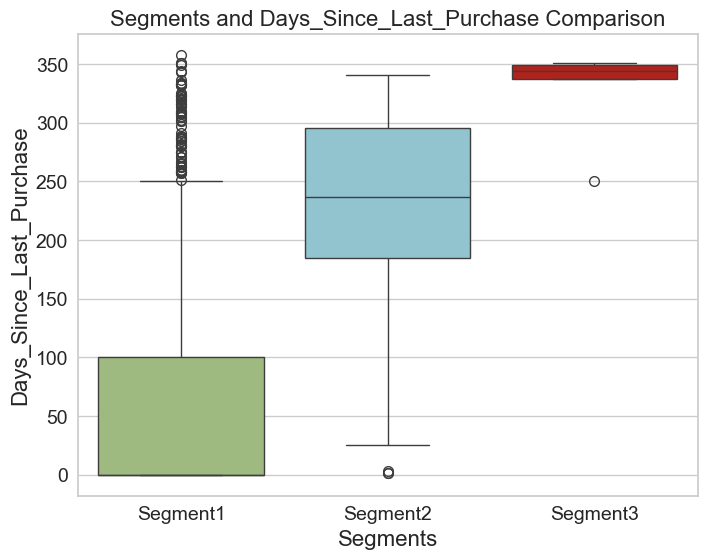

In [84]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'recency' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Days_Since_Last_Purchase'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Days_Since_Last_Purchase', fontsize=16)
plt.xlabel('Segments', fontsize=16)
plt.title('Segments and Days_Since_Last_Purchase Comparison', fontsize=16)

# Increase x-axis tick label font size
plt.xticks(fontsize=14)

# Increase y-axis tick label font size
plt.yticks(fontsize=14)

plt.show()

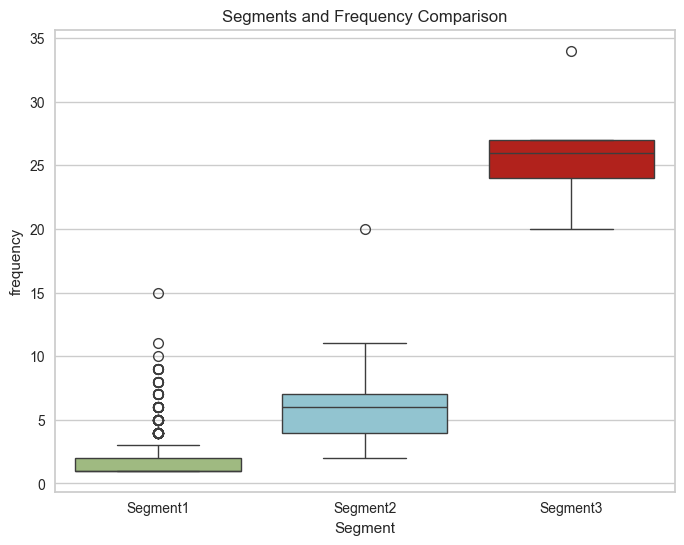

In [85]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['frequency'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('frequency')
plt.title('Segments and Frequency Comparison')

plt.show()

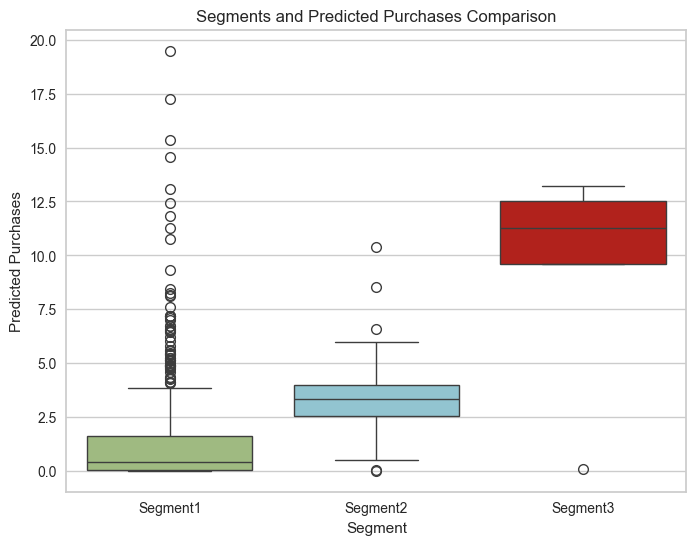

In [86]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Predicted_Purchases'], palette=['g','c','r'])

# Setting labels and title
plt.ylabel('Predicted Purchases')
plt.title('Segments and Predicted Purchases Comparison')

plt.show()

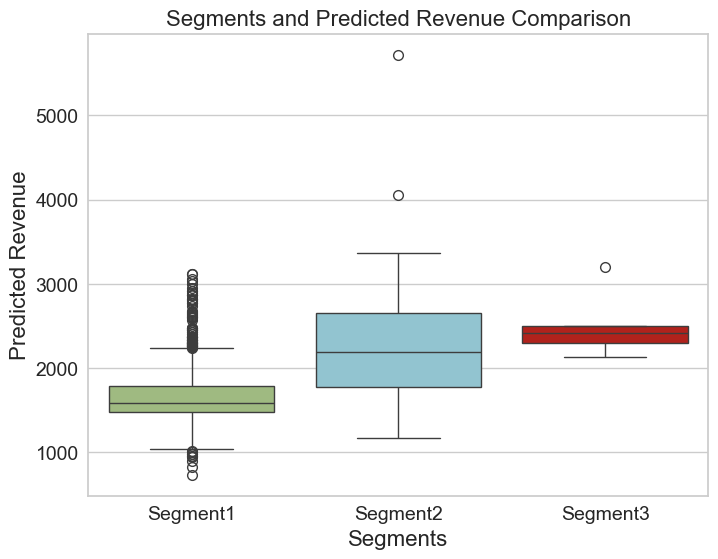

In [87]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['Predicted_Revenue'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Predicted Revenue', fontsize=16)
plt.xlabel('Segments', fontsize=16)
plt.title('Segments and Predicted Revenue Comparison', fontsize=16)

# Increase x-axis tick label font size
plt.xticks(fontsize=14)

# Increase y-axis tick label font size
plt.yticks(fontsize=14)

plt.show()

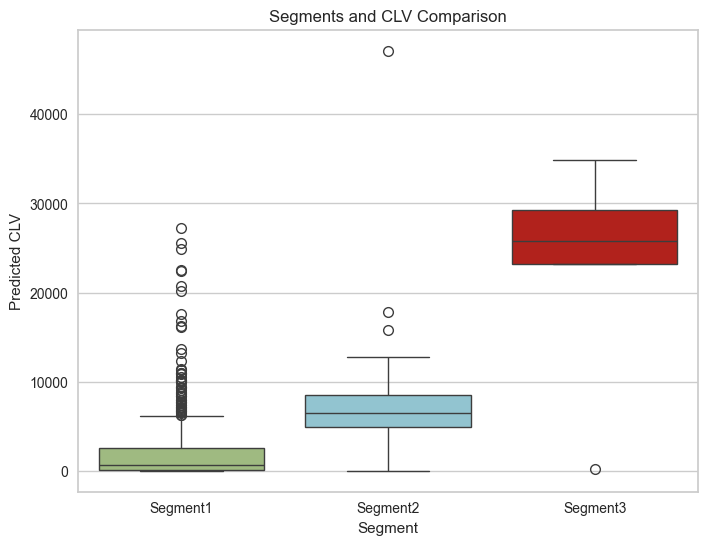

In [88]:
plt.figure(figsize=(8, 6))

# Creating a boxplot to compare 'frequency' across different segments
s = sns.boxplot(x=customer_analysis_hk['Segment'], y=customer_analysis_hk['CLV'], palette=['g','c', 'r'])

# Setting labels and title
plt.ylabel('Predicted CLV')
plt.title('Segments and CLV Comparison')

plt.show()

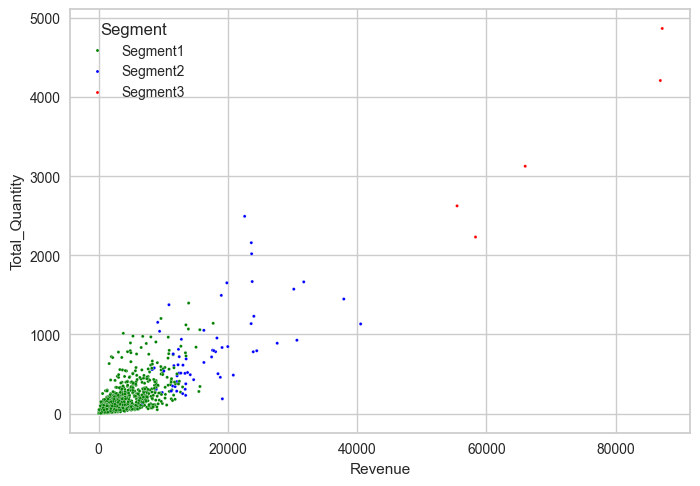

In [89]:
custom_palette = {
    'Segment1': 'green',  # Assigning 'green' to the segment with value 0
    'Segment2': 'blue',# Assigning 'blue' to the segment with value -1
    'Segment3': 'red'
    # Add more colors as needed for other unique segment values
}

# Create the scatterplot using the defined palette and 'Segment' as hue
sns.scatterplot(
    x="Revenue",
    y="Total_Quantity",
    hue="Segment",
    s=5,
    data=customer_analysis_hk,
    palette=custom_palette
);

**Clustering Analysis:DBSCAN & Hierarchical**
- Segment2 is a high valued group whereas Segment1 is a low valued group
- Segment 2 customers yield higher revenue, higher purchasing frequency, and higher customer lifetime value


**Final Clustering Evaluation**
- Choose 4 segments from KMeans as final segmentation because number of customers in each segment is proportionate, whereas 2 segments obtained from DBSCAN and Hierarchical are heavily unproportionated

#### Segment Comparison by Purchased Products

In [90]:
# Combine kmeans clustered df to product analysis
km_df= customer_analysis_km.merge(product_analysis, how='inner')

In [91]:
# Preview km_df data
km_df.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,...,Tenure_Days,Predicted_Purchases,Predicted_Revenue,CLV,Segment,color,Purchased_Products,Products_SKUs,Product_Categories,Product_Group
0,12346,25.49,150.00,2,3,1,0,31,2.0,0.0,...,107.0,0.175161,1488.523498,251.968402,Segment6,brown,[Android Men's Engineer Short Sleeve Tee Charc...,"[GGOEAAAJ080816, GGOEGOAR013099]","[Apparel, Office]","[Android, Google]"
1,12347,3746.16,665.14,60,342,1,1,20,20.0,14.0,...,282.0,1.796198,2798.601724,4856.521721,Segment2,green,"[Four Color Retractable Pen, Red Spiral Google...","[GGOEGOAQ020099, GGOEGOCT019199, GGOENEBJ07949...","[Office, Nest, Bags, Drinkware, Headgear, Appa...","[No-Brand, Google, YouTube, Android]"
2,12348,336.52,197.15,23,209,2,1,39,11.0,1.0,...,192.0,1.607770,1491.563966,2317.038963,Segment1,blue,"[26 oz Double Wall Insulated Bottle, Google St...","[GGOEGDHQ015399, GGOEGOAR013099, GGOEGBMJ01339...","[Drinkware, Office, Bags, Lifestyle, Apparel, ...","[No-Brand, Google, YouTube]"
3,12350,1312.40,127.88,17,21,2,1,25,6.0,3.0,...,17.0,2.259136,1659.302471,3623.714932,Segment1,blue,[Nest Learning Thermostat 3rd Gen-USA - Stainl...,"[GGOENEBJ079499, GGOENEBQ081599, GGOEGAEL09131...","[Nest, Apparel, Headgear]",[Google]
4,12356,1244.83,637.49,36,56,4,0,31,11.0,8.0,...,107.0,0.175161,1730.654802,292.954948,Segment6,brown,"[YouTube Men's Short Sleeve Hero Tee White, R...","[GGOEYAAQ031717, GGOEGDWR015799, GGOEGADC05931...","[Apparel, Drinkware, Nest, Bags, Office, Lifes...","[YouTube, No-Brand, Google, Android]"


In [92]:
# Group Quantity by Product Categories, Product Groups, and Product Descriptions
category_quantity = sales.groupby(['CustomerID', 'Product_Category'])['Quantity'].sum().reset_index()
group_quantity = sales.groupby(['CustomerID', 'Product_Group'])['Quantity'].sum().reset_index()
product_quantity = sales.groupby(['CustomerID', 'Product_Description'])['Quantity'].sum().reset_index()

In [93]:
segment_category_df = customer_analysis_km.merge(category_quantity, how='inner')
segment_group_df = customer_analysis_km.merge(group_quantity, how='inner')
segment_product_df = customer_analysis_km.merge(product_quantity, how='inner')

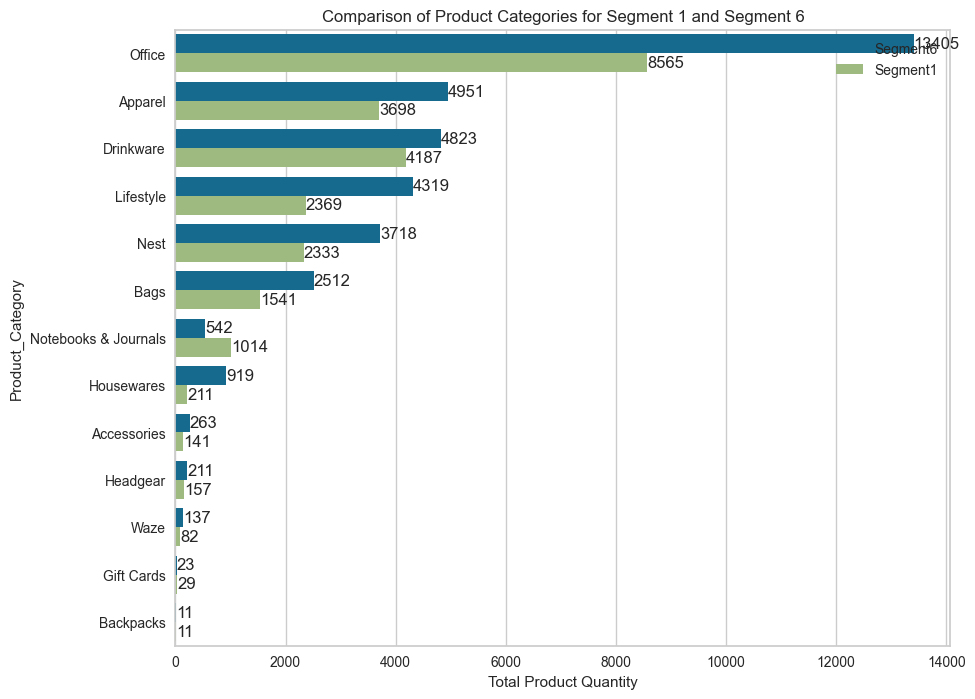

In [95]:
# Filter data for Segment 1 and Segment 6
segments_to_plot = ['Segment1', 'Segment6']
filtered_data = segment_category_df[segment_category_df['Segment'].isin(segments_to_plot)]

# Calculate the total quantity of each product category across segments 1 and 6
category_totals = filtered_data.groupby(['Product_Category', 'Segment'])['Quantity'].sum().reset_index()

# Sort the data by the 'Quantity' column for better visualization
category_totals_sorted = category_totals.sort_values(by='Quantity', ascending=False)

plt.figure(figsize=(10, 8))

# Create a horizontal bar plot for Segment 1 and Segment 6
s = sns.barplot(y='Product_Category', x='Quantity', hue='Segment', data=category_totals_sorted,
                order=category_totals_sorted['Product_Category'], orient='h', errwidth=0)

# Adding labels to the bars displaying the count of each segment's product categories
for container in s.containers:
    s.bar_label(container)

# Set labels and title
plt.xlabel('Total Product Quantity')
plt.title('Comparison of Product Categories for Segment 1 and Segment 6')
plt.legend(loc='upper right')

plt.show()

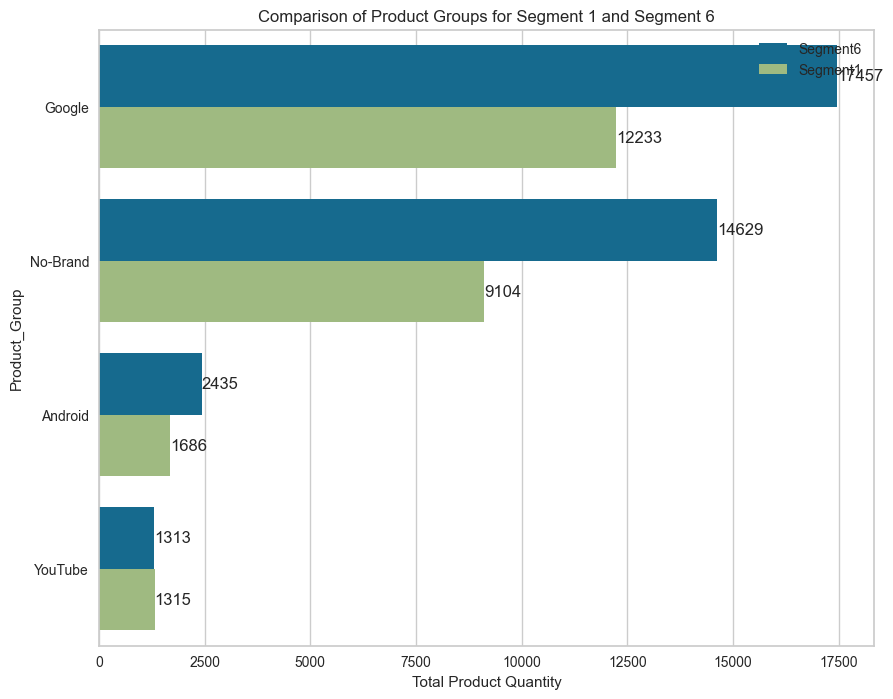

In [96]:
# Filter data for Segment 1 and Segment 6
segments_to_plot = ['Segment1', 'Segment6']
filtered_data = segment_group_df[segment_group_df['Segment'].isin(segments_to_plot)]

# Calculate the total quantity of each product group across segments 1 and 6
group_totals = filtered_data.groupby(['Product_Group', 'Segment'])['Quantity'].sum().reset_index()

# Sort the data by the 'Quantity' column for better visualization
group_totals_sorted = group_totals.sort_values(by='Quantity', ascending=False)

plt.figure(figsize=(10, 8))

# Create a horizontal bar plot for Segment 1 and Segment 6
s = sns.barplot(y='Product_Group', x='Quantity', hue='Segment', data=group_totals_sorted,
                order=group_totals_sorted['Product_Group'], orient='h', errwidth=0)

# Adding labels to the bars displaying the count of each segment's product groups
for container in s.containers:
    s.bar_label(container)

# Set labels and title
plt.xlabel('Total Product Quantity')
plt.title('Comparison of Product Groups for Segment 1 and Segment 6')
plt.legend(loc='upper right')

plt.show()

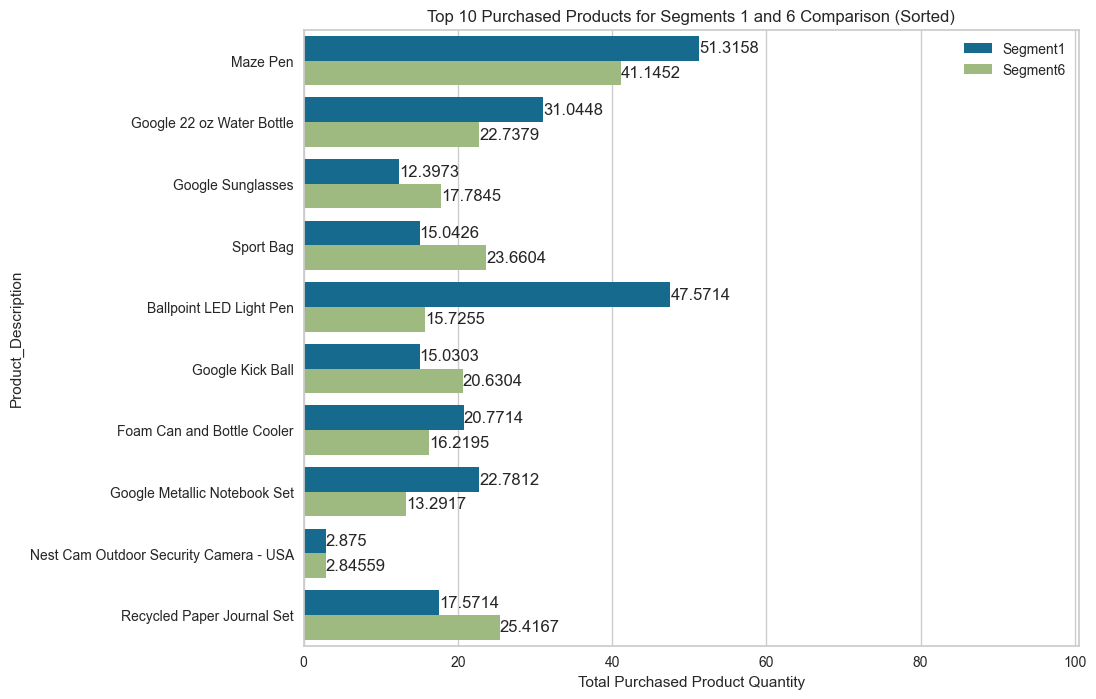

In [97]:
# Filter data for Segment 1 and Segment 6
segments_to_plot = ['Segment1', 'Segment6']
filtered_data = segment_product_df[segment_product_df['Segment'].isin(segments_to_plot)]

# Calculate the total quantity of each product category across segments 1 and 6
total_quantity_per_product = filtered_data.groupby('Product_Description')['Quantity'].sum().reset_index()

# Sort 'Product_Description' based on the total quantities of segments 1 and 6 combined
sorted_products = total_quantity_per_product.sort_values(by='Quantity', ascending=False)['Product_Description']

# Filter the original DataFrame to include only the top 10 products
top_10_segment_products = filtered_data[filtered_data['Product_Description'].isin(sorted_products.head(10))]

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Creating a horizontal bar plot with data of top 10 products for segments 1 and 6 (sorted)
s = sns.barplot(y='Product_Description', x='Quantity', hue='Segment', data=top_10_segment_products,
                order=sorted_products.head(10), orient='h', errwidth=0)

# Adding labels to the bars displaying the count of each segment's purchased products
for container in s.containers:
    s.bar_label(container)

# Setting labels and title
plt.xlabel('Total Purchased Product Quantity')
plt.title('Top 10 Purchased Products for Segments 1 and 6 Comparison (Sorted)')
plt.legend(loc='upper right')

plt.show()

### Market Basket

- Promotion for purchasing 2 associated items (same basket)
- Support: Frequency of purchasing the product: total purchase of A / total transaction
- Confidence: Likelihood of purchasing this item when the other item is purchased: support(A, B)/support(A)
- Lift: The likelihood of purchasing both product compared to purchasing individually: support(A,B)/support(A)*support(B)
      

In [87]:
# Create single_transaction column that concatenates CustomerID seperated by '_' with Transaction_Date
sales['single_transaction'] = sales['CustomerID'].astype(str)+'_'+sales['Transaction_Date'].astype(str)

In [88]:
# Creates a cross-tabulation between 'single_transaction' and 'Product_Description' columns in 'sales' df
# It counts the occurences of each unique combination of 'single_transaction' and 'Product_Description'
df2 = pd.crosstab(sales['single_transaction'], sales['Product_Description'])
df2.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
single_transaction,,,,,,,,,,,,,,,,,,,,,
12346_2019-09-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-03-24,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-11-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-11-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12348_2019-06-22,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Apply encode function to each cell in df2
def encode(item_freq):

    # converts each cell value to 1 if the value is greater than 0, otherwise 0
    res = 0
    if item_freq > 0:
        res = 1
    return res

# applymap function apply encode function element-wise to each cell in df2
basket_input = df2.applymap(encode)

In [90]:
basket_input.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
single_transaction,,,,,,,,,,,,,,,,,,,,,
12346_2019-09-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-03-24,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-11-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347_2019-11-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12348_2019-06-22,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Convert basket_input dataframe to boolean
basket_input = basket_input.astype(bool)


In [92]:
# apriori function is used to find frequent itemsets from the basket_input dataframe
#    - 'min_support=0.01' specifies the minimum support threshold for itemsets to be considered frequent.
#    - 'use_colnames=True' is used to indicate that column names from the input DataFrame should be used in the output DataFrame.
frequent_itemsets = apriori(basket_input, min_support=0.01, use_colnames=True)

# association_rules generates association rules from the frequent itemsets found.
#    - 'metric="lift"' specifies the metric to evaluate the association rules.

rules = association_rules(frequent_itemsets, metric="lift")

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Google 22 oz Water Bottle),(1 oz Hand Sanitizer),0.176746,0.036471,0.018392,0.104056,2.853103,0.011945,1.075435,0.788947
1,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.036471,0.176746,0.018392,0.504274,2.853103,0.011945,1.660703,0.674089
2,(Google Kick Ball),(1 oz Hand Sanitizer),0.081359,0.036471,0.010599,0.130268,3.571798,0.007631,1.107846,0.783798
3,(1 oz Hand Sanitizer),(Google Kick Ball),0.036471,0.081359,0.010599,0.290598,3.571798,0.007631,1.294952,0.747283
4,(Google Laptop and Cell Phone Stickers),(1 oz Hand Sanitizer),0.200748,0.036471,0.015274,0.076087,2.086213,0.007953,1.042878,0.651437


In [93]:
# Sort the rules dataframe by 'support', 'confidence', 'lift' descending order
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(50)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4033,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.471633,0.479115,0.341958,0.725050,1.513311,0.115991,1.894470,0.641973
4032,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.479115,0.471633,0.341958,0.713728,1.513311,0.115991,1.845681,0.651194
4139,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.475374,0.479115,0.326060,0.685902,1.431602,0.098301,1.658351,0.574661
4138,(Nest Cam Outdoor Security Camera - USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.479115,0.475374,0.326060,0.680547,1.431602,0.098301,1.642261,0.578788
4041,(Nest Cam Indoor Security Camera - USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.471633,0.475374,0.323878,0.686715,1.444578,0.099676,1.674597,0.582468
4040,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Indoor Security Camera - USA),0.475374,0.471633,0.323878,0.681311,1.444578,0.099676,1.657940,0.586621
32360,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.323878,0.479115,0.256234,0.791145,1.651265,0.101060,2.494008,0.583332
32358,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Cam Indoor Security Camera - USA),0.326060,0.471633,0.256234,0.785851,1.666232,0.102454,2.467283,0.593292
32359,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.341958,0.475374,0.256234,0.749316,1.576267,0.093677,2.092781,0.555571
32363,(Nest Cam Indoor Security Camera - USA),"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.471633,0.326060,0.256234,0.543291,1.666232,0.102454,1.475646,0.756754


In [114]:
# Sort the DataFrame by "support," "confidence," and "lift" columns in descending order
sorted_rules = rules.sort_values(["support", "confidence", "lift"], axis=0, ascending=False)

# Drop duplicate rows while keeping the first occurrence
unique_rules = sorted_rules.drop_duplicates()

unique_rules.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4033,Nest Cam Indoor Security Camera - USA,Nest Cam Outdoor Security Camera - USA,0.471633,0.479115,0.341958,0.725050,1.513311,0.115991,1.894470,0.641973
4032,Nest Cam Outdoor Security Camera - USA,Nest Cam Indoor Security Camera - USA,0.479115,0.471633,0.341958,0.713728,1.513311,0.115991,1.845681,0.651194
4139,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Cam Outdoor Security Camera - USA,0.475374,0.479115,0.326060,0.685902,1.431602,0.098301,1.658351,0.574661
4138,Nest Cam Outdoor Security Camera - USA,Nest Learning Thermostat 3rd Gen-USA - Stainle...,0.479115,0.475374,0.326060,0.680547,1.431602,0.098301,1.642261,0.578788
4041,Nest Cam Indoor Security Camera - USA,Nest Learning Thermostat 3rd Gen-USA - Stainle...,0.471633,0.475374,0.323878,0.686715,1.444578,0.099676,1.674597,0.582468
4040,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Cam Indoor Security Camera - USA,0.475374,0.471633,0.323878,0.681311,1.444578,0.099676,1.657940,0.586621
32360,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Cam Outdoor Security Camera - USA,0.323878,0.479115,0.256234,0.791145,1.651265,0.101060,2.494008,0.583332
32358,"Nest Cam Outdoor Security Camera - USA, Nest L...",Nest Cam Indoor Security Camera - USA,0.326060,0.471633,0.256234,0.785851,1.666232,0.102454,2.467283,0.593292
32359,"Nest Cam Outdoor Security Camera - USA, Nest C...",Nest Learning Thermostat 3rd Gen-USA - Stainle...,0.341958,0.475374,0.256234,0.749316,1.576267,0.093677,2.092781,0.555571
32363,Nest Cam Indoor Security Camera - USA,"Nest Cam Outdoor Security Camera - USA, Nest L...",0.471633,0.326060,0.256234,0.543291,1.666232,0.102454,1.475646,0.756754


In [94]:
# Extract top 10 rows of antecedents,  consequents, support, confidence, and lift sort descending order
rules[["antecedents", "consequents", "support", "confidence","lift"]].sort_values(["lift"],axis = 0, ascending = False).head(30)


,antecedents,consequents,support,confidence,lift
268150,"(Nest Secure Alarm System Starter Pack - USA, ...","(Nest Cam IQ - USA, Nest Cam Outdoor Security ...",0.010287,0.492537,19.036864
268123,"(Nest Cam IQ - USA, Nest Cam Outdoor Security ...","(Nest Secure Alarm System Starter Pack - USA, ...",0.010287,0.397590,19.036864
268152,"(Nest Cam IQ - USA, Nest Thermostat E - USA, N...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.010287,0.323529,18.870588
268121,"(Nest Cam Outdoor Security Camera - USA, Nest ...","(Nest Cam IQ - USA, Nest Thermostat E - USA, N...",0.010287,0.600000,18.870588
268140,"(Nest Cam Outdoor Security Camera - USA, Nest ...","(Nest Cam IQ - USA, Nest Secure Alarm System S...",0.010287,0.407407,18.407929
268133,"(Nest Cam IQ - USA, Nest Secure Alarm System S...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.010287,0.464789,18.407929
268162,"(Nest Cam IQ - USA, Nest Secure Alarm System S...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.010287,0.388235,18.050128
268111,"(Nest Cam Outdoor Security Camera - USA, Nest ...","(Nest Cam IQ - USA, Nest Secure Alarm System S...",0.010287,0.478261,18.050128
27918,"(Google Tee Blue, Nest Thermostat E - USA)",(Google Tee Green),0.011845,0.527778,17.822222
27923,(Google Tee Green),"(Google Tee Blue, Nest Thermostat E - USA)",0.011845,0.400000,17.822222


In [96]:
# Function to remove brackets
def remove_brackets(text):
    return str(text).replace('(', '').replace(')', '')

# Apply function to 'antecedents' and 'consequents' columns
rules['antecedents'] = rules['antecedents'].apply(remove_brackets)
rules['consequents'] = rules['consequents'].apply(remove_brackets)

In [97]:
# Function to remove frozenset and curly braces
def remove_frozenset(text):
    return str(text).replace('frozenset', '').replace('{', '').replace('}', '').replace("'", '')

# Apply function to 'antecedents' and 'consequents' columns
rules['antecedents'] = rules['antecedents'].apply(remove_frozenset)
rules['consequents'] = rules['consequents'].apply(remove_frozenset)

In [98]:
# Preview the outcome
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,Google 22 oz Water Bottle,1 oz Hand Sanitizer,0.176746,0.036471,0.018392,0.104056,2.853103,0.011945,1.075435,0.788947
1,1 oz Hand Sanitizer,Google 22 oz Water Bottle,0.036471,0.176746,0.018392,0.504274,2.853103,0.011945,1.660703,0.674089
2,Google Kick Ball,1 oz Hand Sanitizer,0.081359,0.036471,0.010599,0.130268,3.571798,0.007631,1.107846,0.783798
3,1 oz Hand Sanitizer,Google Kick Ball,0.036471,0.081359,0.010599,0.290598,3.571798,0.007631,1.294952,0.747283
4,Google Laptop and Cell Phone Stickers,1 oz Hand Sanitizer,0.200748,0.036471,0.015274,0.076087,2.086213,0.007953,1.042878,0.651437


**market basket strategy**
- Match 2 products that are usually purchased together and set promotion deal Ex. Buy Nest Cam Indoor and Nest Cam Outdoor yield cheaper individual price than buying only one

### Product Recommendation

In [99]:
# Retrieves the first 'Product_Description' associated with each unique 'Product_SKU' in the sales dataset
product_name = sales.groupby('Product_SKU')['Product_Description'].first().reset_index()
# Retrieves the first 'Product_Category' associated with each unique 'Product_SKU' in the sales dataset.
product_category = sales.groupby('Product_SKU')['Product_Category'].first().reset_index()
# Retrieves the first 'Product_Group' associated with each unique 'Product_SKU' in the sales dataset.
product_group = sales.groupby('Product_SKU')['Product_Group'].first().reset_index()

# Calculates the mean 'Avg_Price' for each unique 'Product_SKU' in the sales dataset.
price = sales.groupby('Product_SKU')['Avg_Price'].mean().reset_index()

# Calculates the mean 'Revenue' for each unique 'Product_SKU' in the sales dataset.
revenue = sales.groupby('Product_SKU')['Revenue'].mean().reset_index()

# Counts the occurrences of 'Quantity' for each unique 'Product_SKU' in the sales dataset.
quantity = sales.groupby('Product_SKU')['Quantity'].count().reset_index()

# Combine each dataframe above to one dataframe product_df
product_df = pd.merge(product_name, product_group, on='Product_SKU')
product_df = pd.merge(product_df, product_category, on='Product_SKU')
product_df = pd.merge(product_df, price, on='Product_SKU')
product_df = pd.merge(product_df, revenue, on='Product_SKU')
product_df = pd.merge(product_df, quantity, on='Product_SKU')


# Assign meaningful name to each column
product_df.columns = ['Product_SKU', 'Product_Name', 'Product_Category', 'Product_Group', 'Price', 'Revenue', 'Quantity']


In [100]:
# Drop Product_Name column from product_df
product_df.drop(columns=['Product_Name'], inplace=True)

In [101]:
# Converts categorical columns into numerical binary indicators
product_df = pd.get_dummies(product_df, columns=['Product_Category', 'Product_Group'], dtype=int)
# Sets the 'Product_SKU' column as the index of the DataFrame.
product_df.set_index('Product_SKU', drop=True, inplace=True)
product_df.head()

,Price,Revenue,Quantity,Product_Category_Android,Product_Category_Google,Product_Category_No-Brand,Product_Category_YouTube,Product_Group_Accessories,Product_Group_Apparel,Product_Group_Backpacks,Product_Group_Bags,Product_Group_Drinkware,Product_Group_Gift Cards,Product_Group_Headgear,Product_Group_Housewares,Product_Group_Lifestyle,Product_Group_Nest,Product_Group_Notebooks & Journals,Product_Group_Office,Product_Group_Waze
Product_SKU,,,,,,,,,,,,,,,,,,,,
GGOEA0CH077599,13.331875,495.621559,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
GGOEAAAB034813,13.911111,25.801944,18,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
GGOEAAAB034814,12.171395,22.136811,43,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
GGOEAAAB034815,17.833226,34.603767,31,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
GGOEAAAB034816,16.775000,28.227269,22,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Cosine Similarity Definition**
- match similar product itemsets based on counting the maximum number of common attributes between the products

In [102]:
cossim_df = pd.DataFrame(
    # each cell represents the cosine similarity score between the products indexed by the row and column names
    cosine_similarity(product_df), 
    # Product_SKU values are set as index and column names 
    index=product_df.index,
    columns=product_df.index
)

cossim_df.head()

Product_SKU,GGOEA0CH077599,GGOEAAAB034813,GGOEAAAB034814,GGOEAAAB034815,GGOEAAAB034816,GGOEAAAB034817,GGOEAAAB034913,GGOEAAAB034914,GGOEAAAB034915,GGOEAAAB034916,...,GGOEYHPA003510,GGOEYHPA003610,GGOEYHPB072210,GGOEYOBR078599,GGOEYOCB092699,GGOEYOCR077399,GGOEYOCR077799,GGOEYOCR078099,GGOEYOLR018699,GGOEYOLR080599
Product_SKU,,,,,,,,,,,,,,,,,,,,,
GGOEA0CH077599,1.000000,0.776573,0.477700,0.724215,0.742476,0.817178,0.838374,0.579183,0.834323,0.878953,...,0.947518,0.947484,0.420511,0.988812,0.991578,0.966684,0.991115,0.970614,0.627452,0.937623
GGOEAAAB034813,0.776573,1.000000,0.882886,0.992404,0.998587,0.976487,0.991464,0.935512,0.993795,0.982464,...,0.936527,0.921860,0.794138,0.857184,0.831329,0.903127,0.838711,0.886025,0.883879,0.916606
GGOEAAAB034814,0.477700,0.882886,1.000000,0.933274,0.900585,0.766427,0.815507,0.991547,0.861250,0.797029,...,0.713134,0.653194,0.978219,0.602168,0.524765,0.685594,0.587636,0.673326,0.964273,0.749820
GGOEAAAB034815,0.724215,0.992404,0.933274,1.000000,0.995419,0.943197,0.968938,0.971682,0.983853,0.958658,...,0.904312,0.876445,0.862298,0.817214,0.776431,0.873300,0.799976,0.857749,0.929057,0.900556
GGOEAAAB034816,0.742476,0.998587,0.900585,0.995419,1.000000,0.969295,0.984065,0.947817,0.987480,0.971335,...,0.917077,0.900931,0.811971,0.829380,0.801077,0.880280,0.809673,0.861912,0.889868,0.897470


In [120]:
# Create the list of top 6 most simila products to the specified Product_SKU
cossim_df['GGOEAFKQ020599'].sort_values(ascending=False).head(6)

Product_SKU
GGOEAFKQ020599    1.000000
GGOEAFKQ020499    0.999981
GGOEGHGR019499    0.999955
GGOEGHPB071610    0.999919
GGOEGDHC018299    0.999918
GGOEGHGH019699    0.999855
Name: GGOEAFKQ020599, dtype: float64

In [124]:
# List of top 10 products similar to the specified product SKU sort descending order
top_10_similar_items = list(
    cossim_df\
        .loc['GGOEAFKQ020599']\
        .sort_values(ascending=False)\
        .iloc[:10]\
    .index
)

top_10_similar_items

['GGOEAFKQ020599',
 'GGOEAFKQ020499',
 'GGOEGHGR019499',
 'GGOEGHPB071610',
 'GGOEGDHC018299',
 'GGOEGHGH019699',
 'GGOEAKDH019899',
 'GGOEGAAH034015',
 'GGOEGHGC019799',
 'GGOEGFKQ020799']

In [125]:
# Extract from sales dataframe Product_SKU and Product_Description columns according to top_10_similar_items dataframe
sales.loc[
    sales['Product_SKU'].isin(top_10_similar_items), 
    ['Product_SKU', 'Product_Description']
].drop_duplicates().set_index('Product_SKU').loc[top_10_similar_items]

,Product_Description
Product_SKU,
GGOEAFKQ020599,Android Sticker Sheet Ultra Removable
GGOEAFKQ020499,8 pc Android Sticker Sheet
GGOEGHGR019499,Google Sunglasses
GGOEGHPB071610,Google Twill Cap
GGOEGDHC018299,Google 22 oz Water Bottle
GGOEGHGH019699,Google Sunglasses
GGOEAKDH019899,Windup Android
GGOEGAAH034015,Google Men's Vintage Badge Tee Sage
GGOEGHGC019799,Google Sunglasses


In [106]:
def recommend(row):
    # Loop through the 'Products_SKUs' column of each row
    for i, product_sku in enumerate(row['Products_SKUs']):
    # If it's the first product in the row
        if i == 0:
    # Calculate cosine similarity for the product SKU and fetch top 3 most similar products
            recommend = cossim_df[product_sku].sort_values(ascending=False).head(4).iloc[1:]
        else:
    # Calculate cosine similarity for the product SKU and fetch top 3 most similar products
            recommend_next = cossim_df[product_sku].sort_values(ascending=False).head(4).iloc[1:]
    # Concatenate the recommendations
            recommend = pd.concat([recommend, recommend_next])
    # Sort the recommendations based on similarity and retrieve the top 3
    recommend = recommend.sort_values(ascending=False).head(3) # get top 3 product ID
    # Create a list of tuples containing Product_ID and Product_Description for the recommended items
    return [(product_id, products.at[product_id,'Product_Description']) for product_id in recommend.index]
    
# Apply the recommend function row-wise to the DataFrame 'product_analysis' using apply() function
product_analysis['Recommended_Products'] = product_analysis.apply(lambda row: recommend(row), axis=1)

In [107]:
product_analysis.columns

Index(['CustomerID', 'Purchased_Products', 'Products_SKUs',
       'Product_Categories', 'Product_Group', 'Recommended_Products'],
      dtype='object')

In [108]:
# Preview the recommended_products outcome
product_analysis[['CustomerID', 'Purchased_Products', 'Recommended_Products']].head(30)


,CustomerID,Purchased_Products,Recommended_Products
0,12346,[Android Men's Engineer Short Sleeve Tee Charc...,"[(GGOEGBJC019999, Collapsible Shopping Bag), (..."
1,12347,"[Four Color Retractable Pen, Red Spiral Google...","[(GGOEGAEL031113, Google Men's Heavyweight Lon..."
2,12348,"[26 oz Double Wall Insulated Bottle, Google St...","[(GGOEAKDH019899, Windup Android), (GGOEGFKQ02..."
3,12350,[Nest Learning Thermostat 3rd Gen-USA - Stainl...,"[(GGOENEBB078899, Nest Cam Indoor Security Cam..."
4,12356,"[YouTube Men's Short Sleeve Hero Tee White, R...","[(GGOEAKDH019899, Windup Android), (GGOEYFKQ02..."
5,12359,"[Google Blackout Cap, Nest Learning Thermostat...","[(GGOEGAAH034017, Google Men's Vintage Badge T..."
6,12370,[Google 17 oz Double Wall Stainless Steel Insu...,"[(GGOEAKDH019899, Windup Android), (GGOEGHGH01..."
7,12373,"[Google Twill Cap, Google Metallic Notebook Se...","[(GGOEGFKA022299, Keyboard DOT Sticker), (GGOE..."
8,12377,"[Nest Cam Indoor Security Camera - USA, Nest L...","[(GGOEAKDH019899, Windup Android), (GGOEYFKQ02..."
9,12383,"[Google Men's Vintage Badge Tee Black, Nest Ca...","[(GGOEGAAH034017, Google Men's Vintage Badge T..."


In [109]:
#product_analysis.to_csv('recommended_products.csv')

**Product Recommendation Strategy**
- Recommend products to the specific customer browser view based on the  purchased products similarities

**Marketing Strategies**
- Segment 1/Segment 2/Segment 3:
    1. recommend market basket promotion -> purchasing a bundle of products will receive a better price deal
    2. push coupon usage -> could increase the customer's spending and purchases
    3. product recommendation -> recommend similar products in the main webpage and in the specific product webpage -> could potentially increase customer click and engagement
    4. increase marketing spend targeting this group
